# <h1 align="center"><b>PREDICTING DOWNHOLE MOTOR FAILURE WITH MACHINE LEARNING</b></h1>

The performance and reliability of downhole mud motors are essential to the success of modern directional drilling operations. Operating in highly dynamic and high-pressure environments, these motors are frequently subjected to conditions that lead to progressive wear, inefficient drilling, or sudden catastrophic failure. Despite their importance, many operations lack robust, real-time diagnostic frameworks to anticipate and mitigate these failures.

This notebook presents a comprehensive, end-to-end analytical workflow for detecting, analyzing, and predicting downhole motor failures using high-resolution surface and downhole drilling data. The project seamlessly integrates drilling engineering domain expertise with advanced data science and machine learning methodologies to extract actionable insights from raw telemetry.

Key Technical Components:
- Multi-well data harmonization and transformation, aligning disparate sensor records and motor metadata into a unified, depth- and time-synchronized data structure.

- Event detection, including depth advancement calculation, time deltas, pressure differential shifts, and rotary-slide transition tracking.

- Automated stall detection based on dynamic thresholds in torque and pressure behavior—derived from real-world failure patterns.

- Multivariate anomaly detection using Isolation Forest models on hydraulic and mechanical signals to reveal early indicators of dysfunction or instability.

- Domain-specific feature engineering, such as circulating time, cumulative footage drilled, instability scoring, and drilling dysfunction patterns.

- Exploratory Visualizations and statistical diagnostics that connect model outputs back to drilling behaviors and operational decisions—closing the loop between prediction and interpretation.

- Supervised machine learning model development, where labeled failure states are used to train classifiers that learn predictive patterns from engineered features.

- Model evaluation and diagnostics, including accuracy, recall, precision, and confusion matrix analysis to validate predictive performance on unseen data.



This project represents a forward-leaning example of intelligent automation in drilling analytics. By bridging real-time data, physical process understanding, and predictive modeling, it establishes a pathway toward smarter rig-site monitoring systems and more resilient, data-driven drilling operations.

## Initial Imports
In this initial section, we import foundational Python libraries that form the backbone of our data analysis pipeline. NumPy and pandas will handle numerical and tabular data, while matplotlib and seaborn provide visualization capabilities crucial for exploratory analysis. Additionally, we bring in StandardScaler, IsolationForest, and silhouette_score—tools critical for scaling data and identifying anomalies in multidimensional space. Suppressing warnings ensures a clean and focused development environment.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score

%matplotlib inline

import warnings
# Turn off all warnings
warnings.filterwarnings('ignore')

## Dataset Loading
Here, we load a raw time-series dataset of drilling parameters captured during a directional well operation. The dataset includes over 290+ columns representing sensor readings, mechanical parameters, and rig-state variables. 

In [8]:
df1 = pd.read_csv(r"C:\Users\hp\Datasets\Utah Forge Datasets\56-32_Pason_Archive\27029986-3.csv")
df1.columns

Index(['YYYY/MM/DD', 'HH:MM:SS', 'Hole Depth (feet)', 'Bit Depth (feet)',
       'Rate Of Penetration (ft_per_hr)', 'Weight on Bit (klbs)',
       'Hook Load (klbs)', 'Rotary RPM (RPM)', 'Standpipe Pressure (psi)',
       'Rotary Torque (kft_lb)',
       ...
       'Wave Smart Limit Status (unitless)',
       'Wave SP Tracking Status (unitless)', 'Wave Status (unitless)',
       'Wave Stick Slip Status (unitless)',
       'Wave Stick Slip Threshold (unitless)',
       'Wave WOB Correlation (unitless)', 'Wave WOB Delay (unitless)',
       'Wave WOB Integral (klbs)', 'Wave WOB Obj Function (unitless)',
       'Wave WOB Optimizer Status (unitless)'],
      dtype='object', length=296)

### Inspection
We print and sort all the columns alphabetically to facilitate inspection and feature selection. At this stage, we begin to identify parameters of engineering relevance for downhole motor performance analysis—parameters like WOB, RPM, torque, flow rate, and differential pressure are of particular interest.

In [9]:
for i in df1.columns.sort_values(ascending=True):
    print(i)

ADR Slide-Rotate Switch (unitless)
ADiffP (psi)
ADiffPMin (psi)
AMAP Info 1 (unitless)
AMAP Mode (unitless)
ASP Debug	 (psi)
ASW Debug (klbs)
AWOB (klbs)
AWOBMin (klbs)
AutoDriller Block Position (feet)
AutoDriller Block Velocity (ft_per_hr)
AutoDriller Brake Pos (in)
AutoDriller Diff Press (psi)
AutoDriller Diff Press SP (psi)
AutoDriller Diff Pressure Response Tunin (unitless)
AutoDriller Drum Ticks (unitless)
AutoDriller Off Bottom ROP Limit (ft_per_hr)
AutoDriller On Bottom ROP Setpoint (ft_per_hr)
AutoDriller Power Tune (unitless)
AutoDriller ROP Response Tuning (unitless)
AutoDriller Status (unitless)
AutoDriller Status 2 LW (unitless)
AutoDriller Status 2 UW (unitless)
AutoDriller Status 3 LW (unitless)
AutoDriller Status 3 UW (unitless)
AutoDriller Status LW (unitless)
AutoDriller Status UW (unitless)
AutoDriller Throttle (percent)
AutoDriller Ticks Per Depth (tick_per_ft)
AutoDriller Torque (kft_lb)
AutoDriller Torque Limit (kft_lb)
AutoDriller Torque Limit Min (kft_lb)
AutoDr

### Selecting and Inspecting Relevant Features
We define a feature subset, explicitly selecting drilling parameters that are strongly correlated with bit-rock interaction and motor dynamics. Notably, 'Mud Motor Used (unitless)' is used as a binary tag to flag whether drilling was done using a motor or not. This enables us to isolate relevant operational windows for motor performance evaluation. A `.value_counts()` check confirms that a significant majority of the data (~480k samples) involves motor usage, affirming the robustness of our study.

In [10]:
selected = [
    # "Circulating Hours (hrs)",
    # "DAS Score (unitless)",
    # "DAS Stall Detector Status (unitless)",
    # 'DAS Stall Severity Estimate (unitless)',
    # 'Differential Pressure Min (psi)',
    # 'Motor Max Diff (psi)',
    # 'Motor Max Torque (ft_lb)',
    # 'Motor RPM (RPM)',
    'Mud Motor Used (unitless)',
    'YYYY/MM/DD',
    'HH:MM:SS',
    'Hole Depth (feet)',
    # 'Bit Depth (feet)',
    'Rate Of Penetration (ft_per_hr)',
    'Weight on Bit (klbs)',
    'Hook Load (klbs)',
    'Rotary RPM (RPM)',
    'Standpipe Pressure (psi)',
    'Rotary Torque (kft_lb)',
    'Differential Pressure (psi)',
    'Flow (flow_percent)',
    # 'Block Height (feet)',
    # 'Tool Face (degrees)',
    ]


### Load other parts of the dataset

In [11]:
df2 = pd.read_csv(r"C:\Users\hp\Datasets\Utah Forge Datasets\56-32_Pason_Archive\27029986-4.csv")
df3 = pd.read_csv(r"C:\Users\hp\Datasets\Utah Forge Datasets\56-32_Pason_Archive\27029986-5.csv")
df4 = pd.read_csv(r"C:\Users\hp\Datasets\Utah Forge Datasets\56-32_Pason_Archive\27029986-6.csv")

In [12]:
df1['Mud Motor Used (unitless)'].value_counts()

Mud Motor Used (unitless)
 1.00      479534
 0.00      107269
-999.25         5
Name: count, dtype: int64

### Previewing Selected Dataset
Here, we preview a cleaned dataframe that contains only our selected columns. The drilling time-series data is high-resolution (likely sub-second intervals), and parameters like ROP, WOB, RPM, and Torque appear consistent with expected downhole measurements. This step validates the integrity of the ingestion pipeline and confirms readiness for transformation.

In [13]:
df1[selected]

Mud Motor Used (unitless)  YYYY/MM/DD  HH:MM:SS  Hole Depth (feet)  \
0                             0.0  2021/02/08  04:30:00              174.5   
1                             0.0  2021/02/08  04:30:01              174.5   
2                             0.0  2021/02/08  04:30:02              174.5   
3                             0.0  2021/02/08  04:30:03              174.5   
4                             0.0  2021/02/08  04:30:04              174.5   
...                           ...         ...       ...                ...   
586803                        1.0  2021/02/14  23:58:56             4701.7   
586804                        1.0  2021/02/14  23:58:57             4701.7   
586805                        1.0  2021/02/14  23:58:58             4701.7   
586806                        1.0  2021/02/14  23:58:59             4701.7   
586807                        1.0  2021/02/14  23:59:00             4701.7   

        Rate Of Penetration (ft_per_hr)  Weight on Bit (klbs)  \
0                                  0.00                   0.0   
1                                  0.00                   0.0   
2                                  0.00                   0.0   
3                                  0.00                   0.0   
4                                  0.00                   0.0   
...                                 ...                   ...   
586803                            17.84                  48.1   
586804                            17.87                  48.0   
586805                            17.90                  47.7   
586806                            17.93                  47.8   
586807                            17.95                  47.8   

        Hook Load (klbs)  Rotary RPM (RPM)  Standpipe Pressure (psi)  \
0                   56.8              0.03                      0.00   
1                   56.8              0.03                      0.00   
2                   56.8              0.03                      0.00   
3                   56.8              0.03                      0.00   
4                   56.8              0.03                      0.00   
...                  ...               ...                       ...   
586803             117.2              0.03                   2796.04   
586804             117.4              0.03                   2795.94   
586805             117.5              0.03                   2793.13   
586806             117.6              0.03                   2791.27   
586807             117.5              0.03                   2791.25   

        Rotary Torque (kft_lb)  Differential Pressure (psi)  \
0                        0.005                         0.00   
1                        0.005                         0.00   
2                        0.005                         0.00   
3                        0.005                         0.00   
4                        0.005                         0.00   
...                        ...                          ...   
586803                   0.000                        78.84   
586804                   0.000                        78.74   
586805                   0.000                        75.93   
586806                   0.000                        74.07   
586807                   0.000                        74.05   

        Flow (flow_percent)  
0                      0.00  
1                      0.00  
2                      0.00  
3                      0.00  
4                      0.00  
...                     ...  
586803                73.56  
586804                75.26  
586805                76.39  
586806                75.80  
586807                75.11  

[586808 rows x 12 columns]

### Defining Transformation and Combination Functions
We modularize the pipeline by defining two core transformation functions:

`slice_columns()` isolates important parameters.

In [14]:
def slice_columns(data):
    columns = [
    'YYYY/MM/DD',
    'HH:MM:SS',
    'Hole Depth (feet)',
    'Mud Motor Used (unitless)',
    'Rate Of Penetration (ft_per_hr)',
    'Weight on Bit (klbs)',
    'Hook Load (klbs)',
    'Rotary RPM (RPM)',
    'Standpipe Pressure (psi)',
    'Rotary Torque (kft_lb)',
    'Differential Pressure (psi)',
    'Flow (flow_percent)',
    'Block Height (feet)',
    ]

    df = data[columns]
    return df

`combine_and_transform()` function merges datasets from multiple wells while creating a unified timestamp column.

This modular design promotes reusability and ensures consistency across different well runs. Importantly, converting date and time into a `TimeStamp` column is essential for temporal alignment of events and subsequent time-differencing operations.

In [15]:
def combine_and_transform(df1, df2, df3, df4):

    wells = [df1, df2, df3, df4]
    well_names = ['well 56-32', 'well 56-32', 'well 56-32', 'well 56-32']
    combined_df = pd.DataFrame()

    for well, well_name in zip(wells, well_names):

        # Select only the columns we want to use with our custom function - slice_columns
        df = slice_columns(well)

        # Add a column to with well_id to distinguish each well data from the other
        df['Well ID'] = well_name

        # Combine all wells data
        combined_df = pd.concat([combined_df, df], ignore_index=True)
        
    # Merge 'YYYY/MM/DD' and 'HH:MM:SS' columns and convert to datetime format
    combined_df['TimeStamp'] = pd.to_datetime(combined_df['YYYY/MM/DD'] + ' ' + combined_df['HH:MM:SS'])
        
    return combined_df

In [16]:
# def transform(df):
#     #Select only the columns we want to use with our custom function - slice_columns
#     df = slice_columns(df)
#     # Merge 'YYYY/MM/DD' and 'HH:MM:SS' columns and convert to datetime format
#     df['TimeStamp'] = pd.to_datetime(df['YYYY/MM/DD'] + ' ' + df['HH:MM:SS'])
    
#     return df
    

In [17]:
# df = transform(df)
# df.head()

In [18]:
df = combine_and_transform(df1, df2, df3, df4)
df.head(5)

YYYY/MM/DD  HH:MM:SS  Hole Depth (feet)  Mud Motor Used (unitless)  \
0  2021/02/08  04:30:00              174.5                        0.0   
1  2021/02/08  04:30:01              174.5                        0.0   
2  2021/02/08  04:30:02              174.5                        0.0   
3  2021/02/08  04:30:03              174.5                        0.0   
4  2021/02/08  04:30:04              174.5                        0.0   

   Rate Of Penetration (ft_per_hr)  Weight on Bit (klbs)  Hook Load (klbs)  \
0                              0.0                   0.0              56.8   
1                              0.0                   0.0              56.8   
2                              0.0                   0.0              56.8   
3                              0.0                   0.0              56.8   
4                              0.0                   0.0              56.8   

   Rotary RPM (RPM)  Standpipe Pressure (psi)  Rotary Torque (kft_lb)  \
0              0.03                       0.0                   0.005   
1              0.03                       0.0                   0.005   
2              0.03                       0.0                   0.005   
3              0.03                       0.0                   0.005   
4              0.03                       0.0                   0.005   

   Differential Pressure (psi)  Flow (flow_percent)  Block Height (feet)  \
0                          0.0                  0.0                167.2   
1                          0.0                  0.0                167.2   
2                          0.0                  0.0                167.2   
3                          0.0                  0.0                167.2   
4                          0.0                  0.0                167.2   

      Well ID           TimeStamp  
0  well 56-32 2021-02-08 04:30:00  
1  well 56-32 2021-02-08 04:30:01  
2  well 56-32 2021-02-08 04:30:02  
3  well 56-32 2021-02-08 04:30:03  
4  well 56-32 2021-02-08 04:30:04

### Loading and Exploring Mud Motor Condition Records
We now ingest a second dataset containing labeled motor failure logs. These records include motor IDs, footage drilled, operational metrics like ROP, WOB, and BHT, and a ground-truth label for motor condition (e.g., “Good,” “Stab wear,” “Broken shaft”). A scatter plot of "Footage Drilled vs Rotating Hours" and "WOB vs BHT" across different failure types provides a visual cue to potential condition-based clustering in feature space.

In [19]:
df_motor = pd.read_excel(r"C:\Users\hp\Techpet Global\Drilling Data Analytics\Datasets\Mudmotor data for wells56-32 and 58-32.xlsx", sheet_name='56-32 mudmotor')
df_motor.head()

Motor ID  Hole Size  Depth In  Depth Out  Footage Drilled     ROP  \
0         1      17.50       134        380              247  484.31   
1         2      12.50       389       3308             2918  367.51   
2         3      12.50      3308       3500              192   64.00   
3         4       8.75      3500       4595             1095   41.10   
4         5       8.75      4595       5143              548   20.10   

   Drill Hours  Add. Circ. Hours  Total Run Hours  Rotating feet  ...  \
0         0.51              2.10             2.61            247  ...   
1         7.94              3.81            11.75           2743  ...   
2         3.00              4.74             7.74            192  ...   
3        26.64              2.00            28.64           2021  ...   
4        26.54              1.02            27.56            501  ...   

   Rotate ROP  Sliding feet  Sliding Hours  Slide ROP  Diff Pressure   Inc  \
0      484.31           NaN            NaN        NaN            350  0.48   
1      389.08         175.0           0.89     196.63            450  0.70   
2       64.00           NaN            NaN        NaN            400  0.70   
3       43.32          74.0           2.64      28.03            300  1.19   
4       20.16          47.0           2.43      19.32            220  0.75   

   WOB    BHT  RPM     Condition  
0    5   85.0   60          Good  
1   48   85.0  100          Good  
2   35  150.8  105     Stab wear  
3   39  138.0   80     Stab wear  
4   45  154.0   50  Bearing wear  

[5 rows x 21 columns]

In [20]:
df_motor.columns

Index(['Motor ID', 'Hole Size', 'Depth In', 'Depth Out', 'Footage Drilled',
       'ROP', 'Drill Hours', 'Add. Circ. Hours', 'Total Run Hours',
       'Rotating feet', 'Rotating Hours', 'Rotate ROP', 'Sliding feet',
       'Sliding Hours', 'Slide ROP', 'Diff Pressure', 'Inc', 'WOB', 'BHT',
       'RPM', 'Condition'],
      dtype='object')

### Visualizing Downhole Motor Failure Records

Columns include Depth In, Depth Out, Footage Drilled, ROP, WOB, differential pressure, BHT, rotating feet/hours, and a categorical Condition (Good, Bearing wear, etc.).

Scatter plots:
Footage Drilled vs. Rotating Hours, colored by Condition, to see whether worn or broken motors tended to accrue disproportionate footage or time.
WOB vs. BHT, colored by Condition, to diagnose whether high bit weight correlates with higher bearing temperature when failure modes arise.

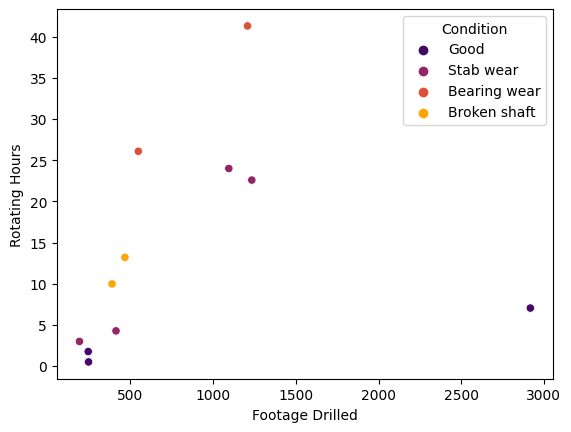

In [21]:
import seaborn as sns # Import seaborn

# Plot the scatter plot using the hue argument
sns.scatterplot(x=df_motor['Footage Drilled'], y=df_motor['Rotating Hours'], hue=df_motor['Condition'], palette='inferno')
plt.xlabel('Footage Drilled')
plt.ylabel('Rotating Hours')
plt.legend(title='Condition') # Add a legend with title
plt.show()


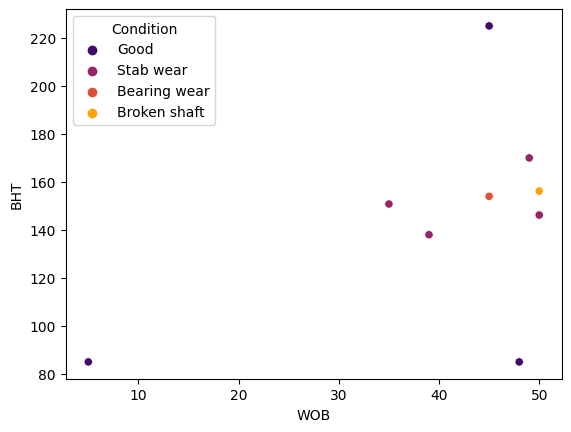

In [22]:
import seaborn as sns # Import seaborn

# Plot the scatter plot using the hue argument
sns.scatterplot(x=df_motor['WOB'], y=df_motor['BHT'], hue=df_motor['Condition'], palette='inferno')
plt.xlabel('WOB')
plt.ylabel('BHT')
# plt.legend(title='Condition') # Add a legend with title
plt.show()


In [23]:
df_motor['Condition'].value_counts()

Condition
Stab wear       4
Good            3
Bearing wear    2
Broken shaft    2
Name: count, dtype: int64

### 3D scatter

Lets add a third axis (differential pressure) to see clusters of failure modes in the 3-D feature space of footage, hours, and pressure.
Condition counts. Only a handful of records per failure type, reminding us this is an imbalanced, small-sample ground truth.

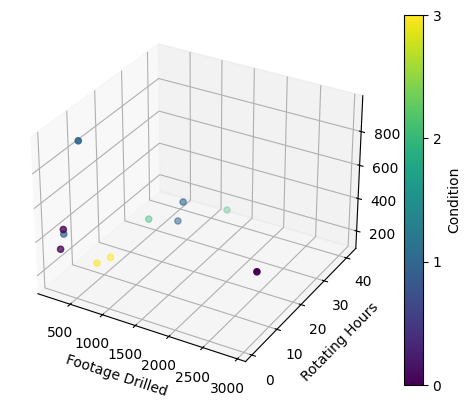

In [24]:
# Import matplotlib and mplot3d
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Create a numeric column from the string column
df_motor['Condition_num'] = df_motor['Condition'].map({'Good': 0, 'Stab wear': 1, 'Bearing wear': 2,'Broken shaft': 3})

# Create the figure and the 3D axes
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plot the 3D scatter plot using the three columns as x, y, and z values
# Assign the scatter plot to a variable p
p = ax.scatter(df_motor['Footage Drilled'], df_motor['Rotating Hours'], df_motor['Diff Pressure'], c=df_motor['Condition_num'], cmap='viridis')

# Set the labels for each axis
ax.set_xlabel('Footage Drilled')
ax.set_ylabel('Rotating Hours')
ax.set_zlabel('Diff Pressure')

# Add a colorbar with labels
# Pass the scatter plot p as the first argument
plt.colorbar(p, ticks=[0, 1, 2, 3], label='Condition')

# Show the plot
plt.show()


In [25]:
df.head(10)

YYYY/MM/DD  HH:MM:SS  Hole Depth (feet)  Mud Motor Used (unitless)  \
0  2021/02/08  04:30:00              174.5                        0.0   
1  2021/02/08  04:30:01              174.5                        0.0   
2  2021/02/08  04:30:02              174.5                        0.0   
3  2021/02/08  04:30:03              174.5                        0.0   
4  2021/02/08  04:30:04              174.5                        0.0   
5  2021/02/08  04:30:05              174.5                        0.0   
6  2021/02/08  04:30:06              174.5                        0.0   
7  2021/02/08  04:30:07              174.5                        0.0   
8  2021/02/08  04:30:08              174.5                        0.0   
9  2021/02/08  04:30:09              174.5                        0.0   

   Rate Of Penetration (ft_per_hr)  Weight on Bit (klbs)  Hook Load (klbs)  \
0                              0.0                   0.0              56.8   
1                              0.0                   0.0              56.8   
2                              0.0                   0.0              56.8   
3                              0.0                   0.0              56.8   
4                              0.0                   0.0              56.8   
5                              0.0                   0.0              56.8   
6                              0.0                   0.0              56.8   
7                              0.0                   0.0              56.8   
8                              0.0                   0.0              56.8   
9                              0.0                   0.0              56.8   

   Rotary RPM (RPM)  Standpipe Pressure (psi)  Rotary Torque (kft_lb)  \
0              0.03                       0.0                   0.005   
1              0.03                       0.0                   0.005   
2              0.03                       0.0                   0.005   
3              0.03                       0.0                   0.005   
4              0.03                       0.0                   0.005   
5              0.03                       0.0                   0.005   
6              0.03                       0.0                   0.005   
7              0.03                       0.0                   0.005   
8              0.03                       0.0                   0.005   
9              0.03                       0.0                   0.005   

   Differential Pressure (psi)  Flow (flow_percent)  Block Height (feet)  \
0                          0.0                  0.0                167.2   
1                          0.0                  0.0                167.2   
2                          0.0                  0.0                167.2   
3                          0.0                  0.0                167.2   
4                          0.0                  0.0                167.2   
5                          0.0                  0.0                167.2   
6                          0.0                  0.0                167.2   
7                          0.0                  0.0                167.2   
8                          0.0                  0.0                167.2   
9                          0.0                  0.0                167.2   

      Well ID           TimeStamp  
0  well 56-32 2021-02-08 04:30:00  
1  well 56-32 2021-02-08 04:30:01  
2  well 56-32 2021-02-08 04:30:02  
3  well 56-32 2021-02-08 04:30:03  
4  well 56-32 2021-02-08 04:30:04  
5  well 56-32 2021-02-08 04:30:05  
6  well 56-32 2021-02-08 04:30:06  
7  well 56-32 2021-02-08 04:30:07  
8  well 56-32 2021-02-08 04:30:08  
9  well 56-32 2021-02-08 04:30:09

In [26]:
df.columns

Index(['YYYY/MM/DD', 'HH:MM:SS', 'Hole Depth (feet)',
       'Mud Motor Used (unitless)', 'Rate Of Penetration (ft_per_hr)',
       'Weight on Bit (klbs)', 'Hook Load (klbs)', 'Rotary RPM (RPM)',
       'Standpipe Pressure (psi)', 'Rotary Torque (kft_lb)',
       'Differential Pressure (psi)', 'Flow (flow_percent)',
       'Block Height (feet)', 'Well ID', 'TimeStamp'],
      dtype='object')

### Reshaping Motor Failure Data to Match Depth
To bridge the time-series well data and the motor condition logs, we reshape the motor failure data based on depth intervals. For each motor, we define a range using `Depth In` and `Depth Out`, and assign a numeric label (0 for good, 1 for bad). This reshaping enables us to align time-series samples to the specific depth at which the motor condition is known.

In [28]:
def reshape_motor(data):
    df = data
    # Create a numeric column from the string column
    df_motor['Condition_num'] = df_motor['Condition'].map({'Good': 0, 'Stab wear': 1, 'Bearing wear': 1,'Broken shaft': 1})

    # Create a new dataframe with only the depth in rows
    df_in = df_motor[["Motor ID", "Depth In", "Condition_num"]].rename(columns={"Depth In": "Depth"})
    df_in['Condition_num'] = 0
    df_in['Depth'] = df_in['Depth'] + 0.1

    # Create a new dataframe with only the depth out rows
    df_out = df_motor[["Motor ID", "Depth Out", "Condition_num"]].rename(columns={"Depth Out": "Depth"})

    # Concatenate the two dataframes vertically
    df_reshaped = pd.concat([df_in, df_out])

    # Sort the dataframe by the Motor ID and Depth columns
    df_reshaped = df_reshaped.sort_values(by=["Motor ID", "Depth"])

    # Reset the index of the dataframe
    df_reshaped = df_reshaped.reset_index(drop=True)

    # Return the reshaped dataframe with the new columns
    return df_reshaped


In [29]:
motor_data = reshape_motor(df_motor)
motor_data

Motor ID   Depth  Condition_num
0          1   134.1              0
1          1   380.0              0
2          2   389.1              0
3          2  3308.0              0
4          3  3308.1              0
5          3  3500.0              1
6          4  3500.1              0
7          4  4595.0              1
8          5  4595.1              0
9          5  5143.0              1
10         6  5143.1              0
11         6  5610.0              1
12         7  5610.1              0
13         7  5999.0              1
14         8  5999.1              0
15         8  7207.0              1
16         9  7207.1              0
17         9  7620.0              1
18        10  7666.1              0
19        10  8900.0              1
20        11  8900.1              0
21        11  9145.0              0

### Merge drilling dataset with the mud motor dataset

Using a depth-based outer join, we now annotate every time-series sample in the drilling dataset with the corresponding motor condition. A forward-fill strategy ensures that every drilling point within a motor’s run interval inherits its condition label. This is a critical step: it creates a supervised learning-ready dataset where each data point is paired with a failure condition.

In [30]:
def merge_data(df, df_motor):
    
    # Find the depth in values in df_motor that do not match with the depth values in well56
    no_match = df_motor[~df_motor["Depth"].isin(df["Hole Depth (feet)"])]["Depth"]

    # Print a message if there are any unmatched depth values
    if len(no_match) > 0:
        print("Hey, there was no match for the following depth values:")
        print(no_match)
    else:
        print("All depth values matched!")

    # Merge the two datasets on the depth columns, using an outer join
    df_merged = pd.merge(df, df_motor, left_on="Hole Depth (feet)", right_on="Depth", how="outer")

    # Sort the merged dataset by the depth column
    df_merged = df_merged.sort_values(by="Hole Depth (feet)")

    # Fill the missing values in the Motor ID and Condition columns with forward fill method
    df_merged["Motor ID"] = df_merged["Motor ID"].fillna(method="ffill")
    df_merged["Condition_num"] = df_merged["Condition_num"].fillna(method="ffill")

    # Drop the unnecessary columns
    df_merged = df_merged.drop(columns=["Depth"])

    # Return the merged dataset with the new columns
    return df_merged


In [157]:
new_data = merge_data(df, motor_data)
len(new_data)

All depth values matched!


2506182

In [158]:
new_data['Condition_num'].value_counts()

Condition_num
0.0    2130807
1.0     375357
Name: count, dtype: int64

In [159]:
new_data = data10.copy()

In [160]:
new_data.head()

YYYY/MM/DD  HH:MM:SS  Hole Depth (feet)  Mud Motor Used (unitless)  \
0  2021/02/08  04:30:00              174.5                        0.0   
1  2021/02/08  04:30:01              174.5                        0.0   
2  2021/02/08  04:30:02              174.5                        0.0   
3  2021/02/08  04:30:03              174.5                        0.0   
4  2021/02/08  04:30:04              174.5                        0.0   

   Rate Of Penetration (ft_per_hr)  Weight on Bit (klbs)  Hook Load (klbs)  \
0                              0.0                   0.0              56.8   
1                              0.0                   0.0              56.8   
2                              0.0                   0.0              56.8   
3                              0.0                   0.0              56.8   
4                              0.0                   0.0              56.8   

   Rotary RPM (RPM)  Standpipe Pressure (psi)  Rotary Torque (kft_lb)  \
0              0.03                       0.0                   0.005   
1              0.03                       0.0                   0.005   
2              0.03                       0.0                   0.005   
3              0.03                       0.0                   0.005   
4              0.03                       0.0                   0.005   

   Differential Pressure (psi)  Flow (flow_percent)  Block Height (feet)  \
0                          0.0                  0.0                167.2   
1                          0.0                  0.0                167.2   
2                          0.0                  0.0                167.2   
3                          0.0                  0.0                167.2   
4                          0.0                  0.0                167.2   

      Well ID           TimeStamp  Motor ID  Condition_num  Depth difference  \
0  well 56-32 2021-02-08 04:30:00       1.0            0.0               0.0   
1  well 56-32 2021-02-08 04:30:01       1.0            0.0               0.0   
2  well 56-32 2021-02-08 04:30:02       1.0            0.0               0.0   
3  well 56-32 2021-02-08 04:30:03       1.0            0.0               0.0   
4  well 56-32 2021-02-08 04:30:04       1.0            0.0               0.0   

   Time difference  Circulating_Time  
0              0.0                 0  
1              1.0                 0  
2              1.0                 0  
3              1.0                 0  
4              1.0                 0

### Depth Differencing as a Proxy for Drilling Progress
We calculate the first-order depth difference between consecutive samples. This step is vital in identifying actual drilling (positive delta) versus stationary or reaming events (zero delta). These depth differentials can later help filter out non-drilling noise from the dataset.

In [161]:
def depthdiff(df):
    # Sort the DataFrame based on the "TimeStamp" column
    df = df.sort_values(by="TimeStamp")
    
    # Create a new column that contains the depth value of the next row
    df["Next Depth"] = df["Hole Depth (feet)"].shift(-1)

    # Create a new column that contains the forward differencing of all consecutive rows
    df["Depth difference"] =  df["Next Depth"] - df["Hole Depth (feet)"]

    # Round to one d.p
    df["Depth difference"] = df["Depth difference"].round(1)

    # Set the first value of "Depth difference" column to be zero
    df.at[df.index[0], "Depth difference"] = 0

    # Drop the unnecessary column
    df = df.drop(columns=["Next Depth"])

    # Return the dataset with the new column
    return(df)


In [162]:
data1 = depthdiff(new_data)
data1.head()

YYYY/MM/DD  HH:MM:SS  Hole Depth (feet)  Mud Motor Used (unitless)  \
0  2021/02/08  04:30:00              174.5                        0.0   
1  2021/02/08  04:30:01              174.5                        0.0   
2  2021/02/08  04:30:02              174.5                        0.0   
3  2021/02/08  04:30:03              174.5                        0.0   
4  2021/02/08  04:30:04              174.5                        0.0   

   Rate Of Penetration (ft_per_hr)  Weight on Bit (klbs)  Hook Load (klbs)  \
0                              0.0                   0.0              56.8   
1                              0.0                   0.0              56.8   
2                              0.0                   0.0              56.8   
3                              0.0                   0.0              56.8   
4                              0.0                   0.0              56.8   

   Rotary RPM (RPM)  Standpipe Pressure (psi)  Rotary Torque (kft_lb)  \
0              0.03                       0.0                   0.005   
1              0.03                       0.0                   0.005   
2              0.03                       0.0                   0.005   
3              0.03                       0.0                   0.005   
4              0.03                       0.0                   0.005   

   Differential Pressure (psi)  Flow (flow_percent)  Block Height (feet)  \
0                          0.0                  0.0                167.2   
1                          0.0                  0.0                167.2   
2                          0.0                  0.0                167.2   
3                          0.0                  0.0                167.2   
4                          0.0                  0.0                167.2   

      Well ID           TimeStamp  Motor ID  Condition_num  Depth difference  \
0  well 56-32 2021-02-08 04:30:00       1.0            0.0               0.0   
1  well 56-32 2021-02-08 04:30:01       1.0            0.0               0.0   
2  well 56-32 2021-02-08 04:30:02       1.0            0.0               0.0   
3  well 56-32 2021-02-08 04:30:03       1.0            0.0               0.0   
4  well 56-32 2021-02-08 04:30:04       1.0            0.0               0.0   

   Time difference  Circulating_Time  
0              0.0                 0  
1              1.0                 0  
2              1.0                 0  
3              1.0                 0  
4              1.0                 0

### Time Differencing to Analyze Drilling Rate
Time differencing gives us the temporal resolution between events—essential for computing real ROP metrics and identifying anomalous stalls or sudden changes in drilling behavior. It also helps detect irregular sampling or interruptions in the time series.

In [163]:
def timediff(df):
    # Convert the timestamp values from string format to datetime format
    df["TimeStamp"] = pd.to_datetime(df["TimeStamp"])
    
    # Sort the DataFrame based on the "TimeStamp" column
    df = df.sort_values(by="TimeStamp")

    # Create a new column that contains the timestamp value of the next row
    df["Next Time"] = df["TimeStamp"].shift(-1)

    # Create a new column that contains the time differencing of all consecutive rows in seconds
    df["Time difference"] = (df["Next Time"] - df["TimeStamp"]).dt.total_seconds()

    # Set the first value of "Depth difference" column to be zero
    df.at[df.index[0], "Time difference"] = 0

    # Drop the unnecessary column
    df = df.drop(columns=["Next Time"])

    # Print the dataset with the new column
    return df

In [164]:
data2 = timediff(data1)
data2.head()

YYYY/MM/DD  HH:MM:SS  Hole Depth (feet)  Mud Motor Used (unitless)  \
0  2021/02/08  04:30:00              174.5                        0.0   
1  2021/02/08  04:30:01              174.5                        0.0   
2  2021/02/08  04:30:02              174.5                        0.0   
3  2021/02/08  04:30:03              174.5                        0.0   
4  2021/02/08  04:30:04              174.5                        0.0   

   Rate Of Penetration (ft_per_hr)  Weight on Bit (klbs)  Hook Load (klbs)  \
0                              0.0                   0.0              56.8   
1                              0.0                   0.0              56.8   
2                              0.0                   0.0              56.8   
3                              0.0                   0.0              56.8   
4                              0.0                   0.0              56.8   

   Rotary RPM (RPM)  Standpipe Pressure (psi)  Rotary Torque (kft_lb)  \
0              0.03                       0.0                   0.005   
1              0.03                       0.0                   0.005   
2              0.03                       0.0                   0.005   
3              0.03                       0.0                   0.005   
4              0.03                       0.0                   0.005   

   Differential Pressure (psi)  Flow (flow_percent)  Block Height (feet)  \
0                          0.0                  0.0                167.2   
1                          0.0                  0.0                167.2   
2                          0.0                  0.0                167.2   
3                          0.0                  0.0                167.2   
4                          0.0                  0.0                167.2   

      Well ID           TimeStamp  Motor ID  Condition_num  Depth difference  \
0  well 56-32 2021-02-08 04:30:00       1.0            0.0               0.0   
1  well 56-32 2021-02-08 04:30:01       1.0            0.0               0.0   
2  well 56-32 2021-02-08 04:30:02       1.0            0.0               0.0   
3  well 56-32 2021-02-08 04:30:03       1.0            0.0               0.0   
4  well 56-32 2021-02-08 04:30:04       1.0            0.0               0.0   

   Time difference  Circulating_Time  
0              0.0                 0  
1              1.0                 0  
2              1.0                 0  
3              1.0                 0  
4              1.0                 0

### Handling Duplicate Values

We eliminate duplicate depth entries to ensure clean, one-to-one mapping between depth and operational conditions. This streamlines analysis and avoids bias introduced by redundant samples, especially when later computing event rates or aggregating signals.

In [165]:
def check_duplicates(dfa, column):
    # Assuming 'df' is your DataFrame and 'Depth' is the column for which you want to check duplicates
    num_duplicates = dfa[column].duplicated().sum()
    original_length = len(dfa)
    print(f'Number of duplicates in the {column} column: {num_duplicates} out of {original_length}')

def remove_duplicates(dfa, column):

    # Sort the DataFrame based on the "TimeStamp" column
    df = dfa.sort_values(by="TimeStamp") 

    # Drop duplicates in the Hole Depth column and keep the first occurrence
    dfa.drop_duplicates(subset=column, keep="first", inplace=True)

    length = len(dfa[column])

    print(f"The new length of the {column} column is {length}")


In [166]:
check_duplicates(data2, "Hole Depth (feet)")

Number of duplicates in the Hole Depth (feet) column: 2419924 out of 2506182


In [167]:
data3 = remove_duplicates(data2, "Hole Depth (feet)")

The new length of the Hole Depth (feet) column is 86258


In [168]:
data2

YYYY/MM/DD  HH:MM:SS  Hole Depth (feet)  Mud Motor Used (unitless)  \
0        2021/02/08  04:30:00              174.5                        0.0   
499      2021/02/08  04:38:18              134.0                        0.0   
501      2021/02/08  04:38:20              134.1                        0.0   
503      2021/02/08  04:38:22              134.2                        0.0   
507      2021/02/08  04:38:26              134.3                        0.0   
...             ...       ...                ...                        ...   
2506175  2021/03/07  14:19:35             8978.5                        1.0   
2506176  2021/03/07  14:19:36             8978.6                        1.0   
2506177  2021/03/07  14:19:37             8978.7                        1.0   
2506179  2021/03/07  14:19:39             8978.9                        1.0   
2506181  2021/03/07  14:19:41             8979.0                        1.0   

         Rate Of Penetration (ft_per_hr)  Weight on Bit (klbs)  \
0                                   0.00                   0.0   
499                                 2.63                   0.0   
501                                10.10                   0.0   
503                                16.75                   0.0   
507                                28.58                   0.0   
...                                  ...                   ...   
2506175                           316.57                   5.2   
2506176                           316.58                   4.9   
2506177                           316.99                   4.9   
2506179                           317.42                   5.4   
2506181                           318.82                   5.1   

         Hook Load (klbs)  Rotary RPM (RPM)  Standpipe Pressure (psi)  \
0                    56.8              0.03                      0.00   
499                  56.6             59.16                    489.96   
501                  56.6             59.34                    494.92   
503                  56.6             58.70                    506.89   
507                  56.7             59.04                    502.56   
...                   ...               ...                       ...   
2506175             119.4             44.15                   3376.06   
2506176             119.6             44.15                   3375.57   
2506177             119.4             44.15                   3374.17   
2506179             119.4             44.15                   3372.96   
2506181             119.2             44.15                   3378.15   

         Rotary Torque (kft_lb)  Differential Pressure (psi)  \
0                         0.005                         0.00   
499                       3.631                       109.86   
501                       4.234                       114.82   
503                       5.071                       126.79   
507                       4.230                       122.46   
...                         ...                          ...   
2506175                   2.369                       -52.29   
2506176                   2.383                       -52.78   
2506177                   2.365                       -54.19   
2506179                   2.440                       -55.40   
2506181                   2.393                       -50.20   

         Flow (flow_percent)  Block Height (feet)     Well ID  \
0                       0.00                167.2  well 56-32   
499                    84.86                132.0  well 56-32   
501                    82.44                131.9  well 56-32   
503                    76.64                131.9  well 56-32   
507                    80.62                131.7  well 56-32   
...                      ...                  ...         ...   
2506175                 6.47                 40.9  well 56-32   
2506176                 6.41                 40.8  well 56-32   
2506177                 6.32        

In [169]:
# data2.drop_duplicates(subset='Hole Depth (feet)', keep='first', inplace=True)
# len(data2)

In [170]:
len(data2)

86258

### Inspecting the Fault-Labeled Samples
We perform a quick count and visualization of data points labeled with `Condition_num = 1`, indicating motor failure. This step quantifies the imbalance in our dataset—a critical insight for model development where class imbalance must be addressed

In [171]:
data2['Condition_num'].value_counts()

Condition_num
0.0    85788
1.0      468
Name: count, dtype: int64

In [172]:
data2[data2['Condition_num'] == 1]

YYYY/MM/DD  HH:MM:SS  Hole Depth (feet)  Mud Motor Used (unitless)  \
309300   2021/02/11  01:36:44             3500.0                        1.0   
630007   2021/02/14  12:01:31             4595.0                        1.0   
767336   2021/02/15  23:16:07             5143.0                        1.0   
867241   2021/02/17  00:31:17             5610.0                        1.0   
963826   2021/02/18  01:20:55             5999.0                        1.0   
...             ...       ...                ...                        ...   
1530972  2021/02/23  15:56:51             7665.7                        1.0   
1531649  2021/02/23  16:08:07             7665.8                        1.0   
1531656  2021/02/23  16:08:12             7665.9                        1.0   
1531661  2021/02/23  16:08:16             7666.0                        1.0   
1712189  2021/02/26  03:05:50             8900.0                        1.0   

         Rate Of Penetration (ft_per_hr)  Weight on Bit (klbs)  \
309300                             53.41                  34.1   
630007                             16.33                  38.6   
767336                             20.74                  50.3   
867241                             28.48                  48.8   
963826                             13.88                  49.9   
...                                  ...                   ...   
1530972                            12.77                  40.5   
1531649                            20.69                  20.6   
1531656                            30.22                  22.2   
1531661                            36.61                  24.0   
1712189                            40.02                  48.5   

         Hook Load (klbs)  Rotary RPM (RPM)  Standpipe Pressure (psi)  \
309300              113.8             99.08                   3130.33   
630007              118.6             50.03                   2772.30   
767336              123.8             40.56                   3163.03   
867241              128.8             39.25                   3105.49   
963826              135.9              0.06                   3213.84   
...                   ...               ...                       ...   
1530972             190.3             46.11                   3313.77   
1531649             206.6             40.38                   1737.31   
1531656             205.0             40.20                   1752.16   
1531661             203.3             40.29                   1760.61   
1712189             191.8             30.48                   3628.55   

         Rotary Torque (kft_lb)  Differential Pressure (psi)  \
309300                    9.380                       328.65   
630007                    5.071                       114.02   
767336                    3.739                       408.02   
867241                    4.804                       167.31   
963826                    0.000                       510.16   
...                         ...                          ...   
1530972                  10.889                      1874.72   
1531649                   8.693                       354.81   
1531656                   8.898                       369.65   
1531661                   8.622                       378.11   
1712189                  10.123                       228.52   

         Flow (flow_percent)  Block Height (feet)     Well ID  \
309300                 97.82                 60.4  well 56-32   
630007                 66.63                  0.1  well 56-32   
767336                 71.75                 23.2  well 56-32   
867241                 68.44                 32.4  well 56-32   
963826                 67.91                 26.2  well 56-32   
...                      ...                  ...         ...   
1530972                65.30                104.2  well 56-32   
1531649                47.69                104.1  well 56-32   
1531656                48.30        

### Depth Correction

### Visualizing Depth-Time Trajectory with Failures
This interactive Plotly chart plots hole depth vs time with red markers showing motor failures. This serves as a dynamic, domain-intuitive tool for visual correlation between drilling events and eventual motor failure—providing engineers with insight into when and where motor degradation occurred during the run.

In [173]:
import plotly.graph_objects as go

def plot_depth_time(dataplot):
  key_feature = 'Hole Depth (feet)'

  # Sort DataFrame by timestamp
  data = dataplot.sort_values(by='TimeStamp')

  # Create a scatter plot with red dots where Condition is 1
  red_dots = data[data['Condition_num'] == 1]

  # Plotting the time series using Plotly
  fig = go.Figure()
  fig.add_trace(go.Line(x=data['TimeStamp'], y=data[key_feature]));
  fig.update_yaxes(autorange="reversed")  # Invert y-axis

  # Add red dots for Condition equals 1
  fig.add_trace(go.Scatter(
    x=red_dots['TimeStamp'],
    y=red_dots[key_feature],
    name='Motor Fail',
    mode='markers'
  ));

  # Update figure size
  fig.update_layout(width=900, height=400);

  # You can add scatter markers for anomalies (if needed) using:
  # fig.add_trace(go.Scatter(data, x='TimeStamp', y=key_feature, color='red', mode='markers', name='Anomalies'))

  fig.show();


In [174]:
plot_depth_time(data2)

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [175]:
data2['Depth difference'].nsmallest(10)

0      0.0
499    0.0
501    0.0
503    0.0
507    0.0
510    0.0
513    0.0
539    0.0
542    0.0
547    0.0
Name: Depth difference, dtype: float64

In [176]:
print('Start', data2['TimeStamp'].max())
print('End', data2['TimeStamp'].min())

Start 2021-03-07 14:19:41
End 2021-02-08 04:30:00


In [177]:
plot_depth_time(data2[47410:47430]);

In [178]:
data2[data2['Hole Depth (feet)'] == 6000.1].TimeStamp

999785   2021-02-18 06:03:02
Name: TimeStamp, dtype: datetime64[ns]

In [179]:
# data3[47418:47430]

In [180]:
data2[data2['Hole Depth (feet)'] >= 448.7]

YYYY/MM/DD  HH:MM:SS  Hole Depth (feet)  Mud Motor Used (unitless)  \
111470   2021/02/08  06:34:22              448.8                        0.0   
111856   2021/02/08  06:34:23              448.9                        0.0   
112218   2021/02/08  06:40:24              449.0                        0.0   
130572   2021/02/09  16:46:09              448.7                        1.0   
130573   2021/02/09  16:46:13              449.1                        1.0   
...             ...       ...                ...                        ...   
2506175  2021/03/07  14:19:35             8978.5                        1.0   
2506176  2021/03/07  14:19:36             8978.6                        1.0   
2506177  2021/03/07  14:19:37             8978.7                        1.0   
2506179  2021/03/07  14:19:39             8978.9                        1.0   
2506181  2021/03/07  14:19:41             8979.0                        1.0   

         Rate Of Penetration (ft_per_hr)  Weight on Bit (klbs)  \
111470                            293.15                   2.6   
111856                            338.13                   3.2   
112218                             10.50                   3.4   
130572                            781.22                   4.6   
130573                            822.58                   2.6   
...                                  ...                   ...   
2506175                           316.57                   5.2   
2506176                           316.58                   4.9   
2506177                           316.99                   4.9   
2506179                           317.42                   5.4   
2506181                           318.82                   5.1   

         Hook Load (klbs)  Rotary RPM (RPM)  Standpipe Pressure (psi)  \
111470               55.0              0.03                      0.00   
111856               55.2              0.03                      0.00   
112218               54.8              0.03                      0.00   
130572               69.8             61.12                   1951.05   
130573               70.3             60.14                   1960.84   
...                   ...               ...                       ...   
2506175             119.4             44.15                   3376.06   
2506176             119.6             44.15                   3375.57   
2506177             119.4             44.15                   3374.17   
2506179             119.4             44.15                   3372.96   
2506181             119.2             44.15                   3378.15   

         Rotary Torque (kft_lb)  Differential Pressure (psi)  \
111470                    0.005                     -1325.41   
111856                    0.005                     -1325.41   
112218                    0.005                     -1325.41   
130572                    6.786                       145.95   
130573                    3.968                       155.74   
...                         ...                          ...   
2506175                   2.369                       -52.29   
2506176                   2.383                       -52.78   
2506177                   2.365                       -54.19   
2506179                   2.440                       -55.40   
2506181                   2.393                       -50.20   

         Flow (flow_percent)  Block Height (feet)     Well ID  \
111470                  0.00                 92.9  well 56-32   
111856                  0.00                 92.5  well 56-32   
112218                  0.00                 93.0  well 56-32   
130572                102.08                 92.2  well 56-32   
130573                102.32                 91.7  well 56-32   
...                      ...                  ...         ...   
2506175                 6.47                 40.9  well 56-32   
2506176                 6.41                 40.8  well 56-32   
2506177                 6.32        

### Depth-axis corrections & outlier filtering
Plotting the full depth vs. time series with markers at known motor-failure points surfaces aberrant jumps (e.g., negative or huge Δdepth). We apply manual time-stamp filters (dropping known bad ranges) and remove placeholder values (–999.25 ft). After these exclusions, the series spans Feb 8–27, 2021 with a streamlined ~77 K sample backbone.

In [181]:
def depth_correct(data):
    # Filter off the unwanted data
    data = data[data['TimeStamp'] <= '2021-02-27 04:50:47']
    data = data[data['TimeStamp'] != '2021-02-18 06:03:02']
    data = data[(data['TimeStamp'] <= '2021-02-21 06:28:17') | (data['TimeStamp'] >= '2021-02-21 06:37:56')]
    data = data[(data['TimeStamp'] <= '2021-02-21 10:53:15') | (data['TimeStamp'] >= '2021-02-21 11:03:07')]
    data = data[(data['TimeStamp'] <= '2021-02-21 11:56:03') | (data['TimeStamp'] >= '2021-02-24 07:45:22')]
    data = data[(data['TimeStamp'] <= '2021-02-08 06:40:24') | (data['TimeStamp'] >= '2021-02-09 16:46:13')]

    data = data[data['Hole Depth (feet)'] != -999.25]
    data = data[data['Hole Depth (feet)'] != -999.2]
    data = data[(data['Hole Depth (feet)'] <= 380.0) | (data['Hole Depth (feet)'] >= 389.1)]
    data = data[(data['Hole Depth (feet)'] <= 7620.0) | (data['Hole Depth (feet)'] >= 7666.1)]
    data = data[data['Hole Depth (feet)'] <= 9145.0]
   
    
    # Print the first and last dates
    print('Start Date:', data['TimeStamp'].min(), '\n'
          'End Date:', data['TimeStamp'].max(), '\n' 
          'Length of Data:', len(data)
          )
    
    # Resetting index of the concatenated DataFrame
    data.reset_index(drop=True, inplace=True)
    
    return data


In [182]:
data3 = depth_correct(data2)

Start Date: 2021-02-08 04:30:00 
End Date: 2021-02-27 04:50:47 
Length of Data: 77414


In [183]:
x = data3[(data3['TimeStamp'] >= '2021-02-08 06:40:24') & (data3['TimeStamp'] <= '2021-02-09 16:46:13')]
x.tail(10)

YYYY/MM/DD  HH:MM:SS  Hole Depth (feet)  Mud Motor Used (unitless)  \
1579  2021/02/08  06:40:24              449.0                        0.0   
1580  2021/02/09  16:46:13              449.1                        1.0   

      Rate Of Penetration (ft_per_hr)  Weight on Bit (klbs)  Hook Load (klbs)  \
1579                            10.50                   3.4              54.8   
1580                           822.58                   2.6              70.3   

      Rotary RPM (RPM)  Standpipe Pressure (psi)  Rotary Torque (kft_lb)  \
1579              0.03                      0.00                   0.005   
1580             60.14                   1960.84                   3.968   

      Differential Pressure (psi)  Flow (flow_percent)  Block Height (feet)  \
1579                     -1325.41                 0.00                 93.0   
1580                       155.74               102.32                 91.7   

         Well ID           TimeStamp  Motor ID  Condition_num  \
1579  well 56-32 2021-02-08 06:40:24       2.0            0.0   
1580  well 56-32 2021-02-09 16:46:13       2.0            0.0   

      Depth difference  Time difference  Circulating_Time  
1579               0.0              1.0                 0  
1580               0.1              1.0               665

The plot generated by `plot_depth_time(data3)` is our visual confirmation that the `depth_correct` function worked as intended. For a drilling engineer, this chart is intuitive: it shows the progression of `Hole Depth (feet)` over time. After cleaning, we expect to see a more consistent, downward-trending line, representing the drilling progress.

The red dots, marking points where `Condition_num` is 1, represent recorded motor failures. Visualizing them on this corrected depth plot is crucial. We can now see these failures in the context of a cleaner operational timeline. This helps us to start building a mental model of what was happening around the time of each failure. Does failure occur after a long, continuous drilling period? Or after a series of operational interruptions? This plot is the first step in answering those questions.

In [184]:
plot_depth_time(data3)

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




### Computing Depth Differencing After Cleaning
Having cleaned our primary data, it's imperative to recalculate any features derived from it. Here, we re-run the `depthdiff` function on our cleaned `data3` to create `data4`. This ensures our` Depth difference` column, which represents the change in depth between consecutive data points, is not corrupted by the previously removed noise.

Examining the smallest and largest values of this recalculated `Depth difference` is a quality control step.

- `nsmallest(10)` showing values of `0.0` and `0.1` is expected and represents periods of slow drilling or stationary rotation.

- `nlargest(30)` is more insightful. The presence of large values like `46.9`, `14.1`, and `9.1` in what should be a 1-second interval dataset is a red flag. These likely represent remaining data gaps or jumps that weren't caught by our time-based filtering. While we proceed with them for now, we must be mindful that these could be outliers. From a drilling perspective, such a large jump in recorded depth in a short time is physically implausible and points to data logging issues.

In [185]:
data4 = depthdiff(data3)
data4['Depth difference'].nsmallest(10)

0    0.0
1    0.1
2    0.1
3    0.1
4    0.1
5    0.1
6    0.1
7    0.1
8    0.1
9    0.1
Name: Depth difference, dtype: float64

In [186]:
data4['Depth difference'].nlargest(30)

63477    46.9
72634    14.1
1549      9.1
63493     8.0
63492     6.4
63491     6.2
63488     5.4
1557      4.7
1556      4.6
63489     4.6
1555      4.4
1554      4.2
1550      4.0
1551      4.0
1552      4.0
1553      4.0
1558      4.0
4786      4.0
19448     4.0
63485     4.0
63487     4.0
63486     3.6
63490     3.6
1562      3.1
1559      3.0
1560      2.9
1561      2.9
75128     2.9
10991     2.8
23053     2.8
Name: Depth difference, dtype: float64

### Anomaly Detection on Differential Pressure
Now we transition from simple data cleaning to more advanced, automated surveillance. The `detect_anomalies` function introduces a machine learning approach—specifically, the Isolation Forest algorithm—to identify unusual behavior.

For the drilling engineer, an "anomaly" here is not necessarily a failure. It's a data point that deviates significantly from the established norm based on the provided features. In this case, we start by looking at `Differential Pressure (psi)`. High differential pressure is a key indicator of motor performance and load.

The Isolation Forest algorithm is well-suited for this task because it doesn't require pre-labeled "anomaly" data. It works by "isolating" outliers—data points that are easier to separate from the rest of the data cluster. The `contamination` parameter is our handle to tell the model what proportion of the data we expect to be anomalous. Setting it to `0.5` is very high and likely for initial exploration; in a real-world scenario, this would be a much smaller number (e.g., 0.01 to 0.05).

The function then flags these anomalies and, importantly, creates a new feature: `anomaly_count`. This is a cumulative count of anomalies for each motor run. The hypothesis here is that a motor nearing failure might exhibit an increasing number of these anomalous events. This transforms a simple, stateless "is it an anomaly?" flag into a stateful feature that tracks the degradation of the motor over its run life.

In [187]:
def detect_anomalies(df, features, contamination):

    # Anomaly detection using Isolation Forest on all features
    X = df[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    isolation_forest = IsolationForest(contamination=contamination, random_state=42)
    df['IsAnomaly'] = isolation_forest.fit_predict(X_scaled)

    # Filter rows with anomalies
    anomalies = df[df['IsAnomaly'] == 1]
    print(len(anomalies))

    # Replace -1 labels with 1 for anomalies
    anomalies['IsAnomaly'] = anomalies['IsAnomaly'].replace(-1,1)

    #Drop off the unneeded columns
    anomalies = anomalies[['TimeStamp','IsAnomaly']]

    # Merge to original datasets on time stamp
    df = pd.merge(left=df, right=anomalies, how='outer', on='TimeStamp' )

    # Set IsAnomaly to 0 for rows without anomalies
    df['IsAnomaly_y'] = df['IsAnomaly_y'].fillna(0).astype(int)

    # # Drop the intermediate IsAnomaly column
    df.drop(columns=['IsAnomaly_x'], inplace=True)
    df.rename(columns={'IsAnomaly_y': 'IsAnomaly'}, inplace=True)

    # Create 'anomaly_count' column representing cumulative count of anomalies for each 'Motor ID'
    df['anomaly_count'] = df.groupby('Motor ID')['IsAnomaly'].cumsum()

    return df


### Evaluating Anomalies

While the `detect_anomalies` function provides a way to find unusual data points, the `silhouette_values` function provides a way to measure how well the algorithm has performed this separation. The Silhouette Score evaluates the quality of the clusters created by the **Isolation Forest** (where "normal" data is one cluster and "anomalies" are another). It measures how similar a data point is to its own cluster compared to other clusters. A higher score indicates better-defined clusters. By iterating through a range of `contamination` values and plotting their corresponding silhouette scores, we can empirically choose a `contamination` value that best separates the data. This is a more data-driven approach than just guessing the contamination rate.

In [188]:
def silhouette_values(df, features, cont):
    X = df[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    cont_values = [round(x, 2) for x in np.arange(cont[0], cont[1], cont[2])]

    silhouette_scores = []
    contamination_list = []
    
    for contamination in cont_values:
        isolation_forest = IsolationForest(contamination=contamination, random_state=42)
        df['IsAnomaly'] = isolation_forest.fit_predict(X_scaled)
        num_anomalies = np.sum(df['IsAnomaly'] == -1)
        silhouette_avg = silhouette_score(X_scaled, df['IsAnomaly'])
        
        print(f"Contamination: {contamination}, Detected Anomalies: {num_anomalies}, Silhouette Score: {silhouette_avg:.2f}")
        
        # Collect silhouette score and contamination value
        silhouette_scores.append(silhouette_avg)
        contamination_list.append(contamination)

    # Plot silhouette scores against contamination values
    plt.figure(figsize=(8, 6))
    plt.plot(contamination_list, silhouette_scores, marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
    plt.xlabel('Contamination')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Contamination')
    plt.grid(True)
    plt.show()

    return silhouette_scores, contamination_list

### Function to Visualize Anomalies
The `plot_anomalies` function is a crucial visualization tool. It overlays the detected anomalies (as red dots) on the time-series plot of a key feature, in this case, `Differential Pressure (psi)`. This allows the drilling engineer to visually inspect the results and use their domain expertise to validate whether the flagged points are indeed anomalous from an operational standpoint. Do the red dots correspond to sudden spikes or drops in pressure? Do they align with known operational issues? This visual feedback loop is vital for building trust in the model.

In [189]:
def plot_anomalies(df, key_feature, anomaly_column):
    # Sort DataFrame by timestamp
    df_sorted = df.sort_values(by='TimeStamp')
    
    # Plotting the time series with anomalies highlighted (Differential Pressure)
    plt.figure(figsize=(12, 2))  # Increased height for better visualization
    plt.plot(df_sorted['TimeStamp'], df_sorted[key_feature], label=key_feature)
    plt.scatter(df_sorted['TimeStamp'], df_sorted[key_feature], color='red', label='Anomalies')
    plt.xlabel('TimeStamp')
    plt.ylabel(key_feature)
    plt.title(f'Time Series of {key_feature} with Anomalies (All Features)')
    plt.legend()
    plt.show()

# Example usage:
# plot_anomalies(df, 'Differential Pressure', 'Anomaly Column Name')


In [190]:
features =[
    'Differential Pressure (psi)',
    # 'Rate Of Penetration (ft_per_hr)',
    # 'Rotary Torque (kft_lb)',
    # 'Flow (flow_percent)'
    ]

Here, we execute the `detect_anomalies` function with a high contamination factor of 0.5, which results in 38,717 data points being flagged as anomalies. The subsequent plot shows a small time slice (`data5[2100:2200]`) of the 'Differential Pressure' with these anomalies marked. This zoomed-in view is useful for detailed inspection. We can see that the red 'Anomalies' markers are flagging almost every peak and trough in the signal, which is a direct result of the high `contamination` setting.

In [191]:
data5 = detect_anomalies(data4, features, 0.5)

38717


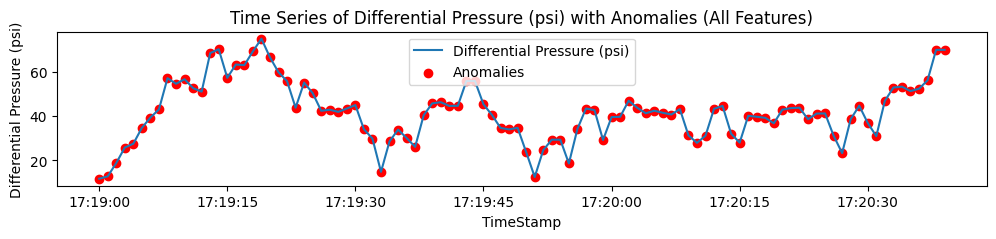

In [192]:
plot_anomalies(data5[2100:2200], 'Differential Pressure (psi)','anomaly_count')

The `value_counts()` on the Differential Pressure and `anomaly_count` columns provide a statistical summary. The pressure counts show the distribution of pressure readings, while the `anomaly_count` distribution is more telling. It shows the cumulative number of anomalies for each motor. A high count for a particular motor could be a strong indicator of its poor health. The goal of this feature engineering is to create variables that have a strong correlation with the motor's eventual failure.

In [193]:
data5['Differential Pressure (psi)'].value_counts()

Differential Pressure (psi)
-1325.41    30
-3193.75    20
 182.19     15
 211.49     13
 211.20     13
            ..
 317.36      1
 258.72      1
 274.35      1
 268.90      1
 424.11      1
Name: count, Length: 29170, dtype: int64

In [194]:
len(data5)

77414

In [196]:
# silhouette_values(data7, features, [0.01, 0.09, 0.01])

In [197]:
data5['anomaly_count'].value_counts()

anomaly_count
29.0      945
31.0      933
4261.0    693
0.0       583
9249.0    486
         ... 
8315.0      1
8314.0      1
8313.0      1
8312.0      1
8192.0      1
Name: count, Length: 9302, dtype: int64

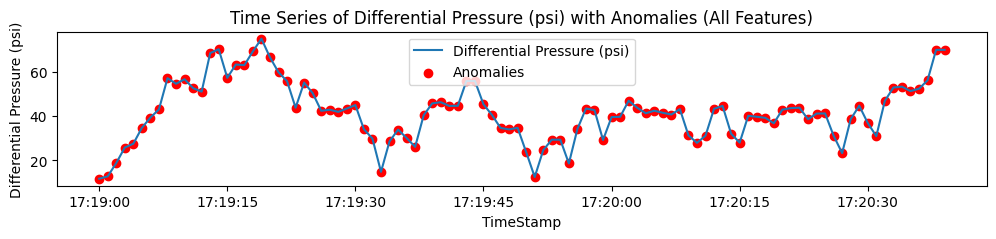

In [198]:
plot_anomalies(data5[2100:2200], 'Differential Pressure (psi)','anomaly_count')

### Engineering Features from Domain Knowledge: Motor Stalls

This section is a prime example of where data science meets domain expertise. We are moving beyond generic anomaly detection to programmatically identify a specific, critical drilling event: a motor stall. A stall occurs when the motor's power output is insufficient to overcome the torque required to turn the bit, leading to a sudden stop or slowdown in rotation.

The `stalls` function codifies the signature of a stall event:

`df['Rate Of Penetration (ft_per_hr)'] > df['Rate Of Penetration (ft_per_hr)'].shift(-1)`: A sharp drop in ROP.

`df['Differential Pressure (psi)'].shift(-1) - df['Differential Pressure (psi)'] < 0`: A sudden drop in differential pressure as the motor unloads.

`df['Rotary Torque (kft_lb)'] < df['Rotary Torque (kft_lb)'].shift(-1)`: A decrease in surface torque.

`abs(df['Flow (flow_percent)'] - df['Flow (flow_percent)'].shift(-1)) <= 0.1`: Consistent flow, indicating the pumps are still running.

This is a powerful piece of feature engineering. We are teaching the machine to recognize a concept that every drilling engineer understands.

Furthermore, we categorize these stalls into low, medium, and high impact based on the quantiles of the differential pressure during the stall. This adds a crucial layer of severity. A motor experiencing frequent, high-impact stalls is likely under significant stress. The function outputs a new DataFrame, stalls_df, containing only these identified stall events, each tagged with a severity level.

In [199]:
# Create a DataFrame from the sample data
def stalls(df):

    # Criteria for motor stall
    stall_criteria = (
        (df['Rate Of Penetration (ft_per_hr)'] > df['Rate Of Penetration (ft_per_hr)'].shift(-1)) &
        (df['Differential Pressure (psi)'].shift(-1) - df['Differential Pressure (psi)'] >= 20) &
        (df['Rotary Torque (kft_lb)'] < df['Rotary Torque (kft_lb)'].shift(-1)) &
        # (df['Flow (flow_percent)'] == df['Flow (flow_percent)'].shift(-1))
        (abs(df['Flow (flow_percent)'] - df['Flow (flow_percent)'].shift(-1)) <= 0.5)
    )
    # Extract motor stalls based on criteria
    motor_stalls = df[stall_criteria]

    # Calculate percentile thresholds for severity levels
    low_threshold = motor_stalls['Differential Pressure (psi)'].quantile(0.5)
    medium_threshold = motor_stalls['Differential Pressure (psi)'].quantile(0.8)

    # Categorize motor stalls based on severity levels
    low_impact_stalls = motor_stalls[motor_stalls['Differential Pressure (psi)'] <= low_threshold]
    medium_impact_stalls = motor_stalls[
        (motor_stalls['Differential Pressure (psi)'] > low_threshold) &
        (motor_stalls['Differential Pressure (psi)'] <= medium_threshold)
    ]
    high_impact_stalls = motor_stalls[motor_stalls['Differential Pressure (psi)'] > medium_threshold]
    
    # Add columns to each dataframe
    low_impact_stalls['stalls'] = 1
    medium_impact_stalls['stalls']  = 2
    high_impact_stalls['stalls'] = 3

    # Concatenate into one datatframe
    df = pd.concat([low_impact_stalls, medium_impact_stalls, high_impact_stalls], axis=0)

    # Resetting index of the concatenated DataFrame
    df.reset_index(drop=True, inplace=True)
    return df


In [200]:
stalls_df = stalls(data5)
stalls_df.head()

YYYY/MM/DD  HH:MM:SS  Hole Depth (feet)  Mud Motor Used (unitless)  \
0  2021/02/08  05:02:53              188.8                        0.0   
1  2021/02/08  05:03:32              194.8                        0.0   
2  2021/02/08  05:04:11              200.0                        0.0   
3  2021/02/08  05:04:15              200.4                        0.0   
4  2021/02/08  05:04:58              207.1                        0.0   

   Rate Of Penetration (ft_per_hr)  Weight on Bit (klbs)  Hook Load (klbs)  \
0                           744.52                   0.3              57.3   
1                           599.79                   0.1              57.5   
2                           402.56                   0.5              57.3   
3                           365.34                   0.3              57.5   
4                           599.30                   0.8              56.9   

   Rotary RPM (RPM)  Standpipe Pressure (psi)  Rotary Torque (kft_lb)  ...  \
0             59.90                   1447.07                   6.361  ...   
1             58.58                   1349.22                   3.374  ...   
2             58.49                   1408.21                   6.164  ...   
3             58.46                   1406.47                   4.547  ...   
4             58.43                   1426.05                   5.977  ...   

      Well ID           TimeStamp  Motor ID Condition_num Depth difference  \
0  well 56-32 2021-02-08 05:02:53       1.0           0.0              0.2   
1  well 56-32 2021-02-08 05:03:32       1.0           0.0              0.1   
2  well 56-32 2021-02-08 05:04:11       1.0           0.0              0.1   
3  well 56-32 2021-02-08 05:04:15       1.0           0.0              0.1   
4  well 56-32 2021-02-08 05:04:58       1.0           0.0              0.1   

   Time difference  Circulating_Time  IsAnomaly  anomaly_count  stalls  
0              1.0                 0          1          202.0       1  
1              1.0                 0          0          220.0       1  
2              1.0                 0          0          231.0       1  
3              1.0                 0          0          232.0       1  
4              1.0                 0          0          264.0       1  

[5 rows x 23 columns]

### Analyzing Stall Severity (Differential-Pressure Spike Analysis)

The output of the `stalls` function is a focused dataset of stall events. The subsequent code filters the main dataset to isolate these "spike_data" points for further analysis.

The histogram is a powerful visual tool for the drilling engineer. It shows the distribution of `Differential Pressure (psi)` values specifically for the identified stall events. By color-coding the bars based on the 50th percentile (p50) and 80th percentile (p80) thresholds, we get an immediate sense of the stall severity distribution.

- Red bars (Left): Low-impact stalls, the most frequent type.

- Green bars (Center): Medium-impact stalls.

- Blue bars (Right): High-impact stalls, the least frequent but most severe.

This visualization confirms that while minor stalls are common, high-impact events are rarer and represent a more significant deviation from normal operation. This distribution is key for understanding the operational envelope and the types of events that might precede a failure.

In [624]:
df = data5
# Filter data for differential pressure spikes based on criteria
spike_data = df[
        (df['Rate Of Penetration (ft_per_hr)'] > df['Rate Of Penetration (ft_per_hr)'].shift(-1)) &
        (df['Differential Pressure (psi)'].shift(-1) - df['Differential Pressure (psi)'] >= 20) &
        (df['Rotary Torque (kft_lb)'] < df['Rotary Torque (kft_lb)'].shift(-1)) &
        (abs(df['Flow (flow_percent)'] - df['Flow (flow_percent)'].shift(-1)) <= 0.5)
        ]

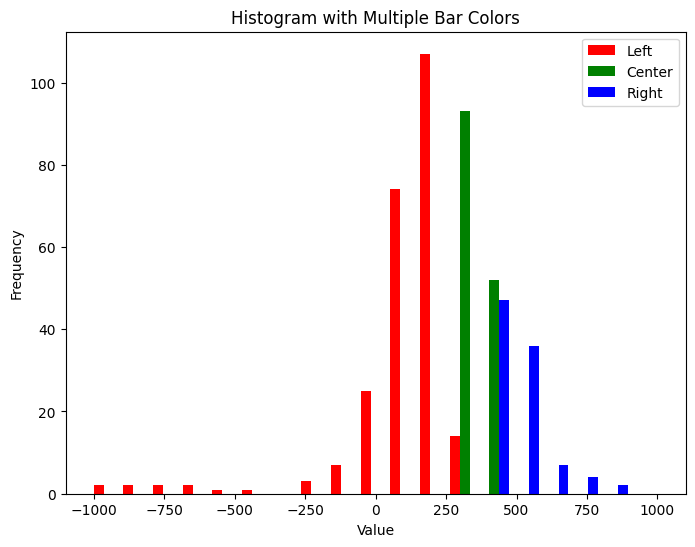

In [615]:
bins = np.linspace(-1000, 1000, 20)
labels = ['Left', 'Center', 'Right']
colors = ['red', 'green', 'blue']

p50 = spike_data['Differential Pressure (psi)'].quantile(0.5)
p80 = spike_data['Differential Pressure (psi)'].quantile(0.8)

left = spike_data[spike_data['Differential Pressure (psi)'] < p50]['Differential Pressure (psi)']
center = spike_data[(spike_data['Differential Pressure (psi)']>= p50) & (spike_data['Differential Pressure (psi)']<= p80)]['Differential Pressure (psi)']
right = spike_data[spike_data['Differential Pressure (psi)'] > p80]['Differential Pressure (psi)']

# Set rwidth to 1 to remove spacing between bars
bar_width = bins[1] - bins[0]  # Width of each bin
plt.figure(figsize=(8, 6))
plt.hist([left, center, right], bins=bins, color=colors, label=labels, align='mid', rwidth=2 * bar_width)

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram with Multiple Bar Colors')
plt.legend()
plt.show()


### Quantifying Stall Impact
The `Distribution Plot` offers a more refined, continuous view of the same data shown in the histogram, with the p50 and p80 thresholds clearly marked as dashed lines. This provides a clearer picture of the shape of the distribution of differential pressure during stalls.

The call to a `Stalls_count` function (not fully shown but implied) and the subsequent `value_counts()` are the quantification of our stall analysis. The output shows we have identified 241 low-impact (`stalls` = 1.0), 144 medium-impact (`stalls` = 2.0), and 96 high-impact (`stalls `= 3.0) stalls in our dataset.

The output `data6['HIS'].max()` revealing a value of 85 is a significant finding. It means that one particular motor run (Motor ID) experienced a cumulative total of 85 high-impact stalls before being pulled out of the hole. This kind of cumulative damage indicator is precisely the type of powerful, predictive feature we are trying to engineer. It's a strong hypothesis that a high cumulative count of severe stalls is a precursor to failure.

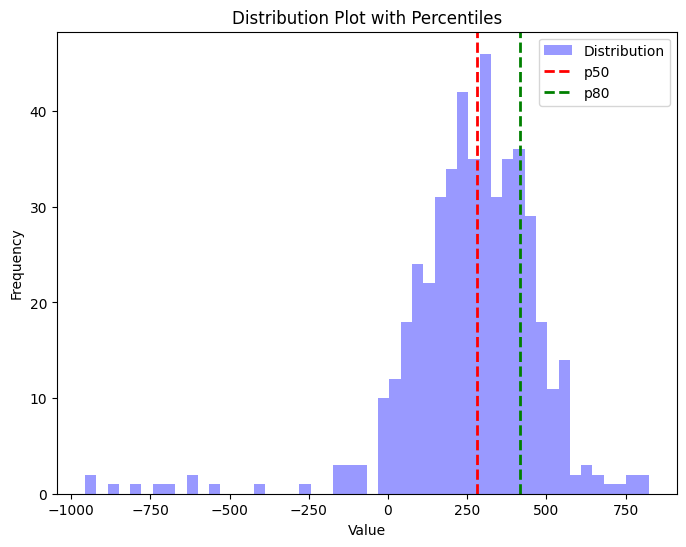

In [618]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Use seaborn's distplot
plt.figure(figsize=(8, 6))
sns.distplot(spike_data['Differential Pressure (psi)'], bins=50, kde=False, color='blue', label='Distribution')

# Assuming you have calculated p50 and p80 as in your previous code
plt.axvline(p50, color='red', linestyle='dashed', linewidth=2, label='p50')
plt.axvline(p80, color='green', linestyle='dashed', linewidth=2, label='p80')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution Plot with Percentiles')
plt.legend()
plt.show()


In [202]:
data6 = Stalls_count(data5, stalls_df)

In [203]:
data6['stalls'].value_counts()

stalls
1.0    241
2.0    144
3.0     96
Name: count, dtype: int64

In [204]:
data6['HIS'].max()

85

In [205]:
# def Stall_Count(df, stall_type):
#     # Group the dataset by the Motor ID column and calculate the cumulative count for each group
#     df[stall_type+"_Count"] = df.groupby("Motor ID")[stall_type].cumsum()
#     return df

In [206]:
data6.head()

YYYY/MM/DD  HH:MM:SS  Hole Depth (feet)_x  Mud Motor Used (unitless)  \
0  2021/02/08  04:30:00                174.5                        0.0   
1  2021/02/08  04:38:18                134.0                        0.0   
2  2021/02/08  04:38:20                134.1                        0.0   
3  2021/02/08  04:38:22                134.2                        0.0   
4  2021/02/08  04:38:26                134.3                        0.0   

   Rate Of Penetration (ft_per_hr)  Weight on Bit (klbs)  Hook Load (klbs)  \
0                             0.00                   0.0              56.8   
1                             2.63                   0.0              56.6   
2                            10.10                   0.0              56.6   
3                            16.75                   0.0              56.6   
4                            28.58                   0.0              56.7   

   Rotary RPM (RPM)  Standpipe Pressure (psi)  Rotary Torque (kft_lb)  ...  \
0              0.03                      0.00                   0.005  ...   
1             59.16                    489.96                   3.631  ...   
2             59.34                    494.92                   4.234  ...   
3             58.70                    506.89                   5.071  ...   
4             59.04                    502.56                   4.230  ...   

   Depth difference  Time difference  Circulating_Time IsAnomaly  \
0               0.0              0.0                 0         0   
1               0.1              1.0                 0         0   
2               0.1              1.0                 0         1   
3               0.1              1.0                 0         1   
4               0.1              1.0                 0         1   

  anomaly_count  HIS  MIS  LIS  Hole Depth (feet)_y  stalls  
0           0.0    0    0    0                  NaN     NaN  
1           NaN    0    0    0                  NaN     NaN  
2           1.0    0    0    0                  NaN     NaN  
3           2.0    0    0    0                  NaN     NaN  
4           3.0    0    0    0                  NaN     NaN  

[5 rows x 27 columns]

### Engineering Features: Rotary/Slide Transitions

Directional drilling often involves switching between rotating the entire drill string from the surface (**rotary drilling**) and orienting the toolface with the top drive and sliding the pipe without rotation, relying solely on the mud motor to turn the bit (**slide drilling**). Each transition from rotary to slide or vice versa can induce vibrations and stress on the Bottom Hole Assembly (BHA), including the motor.

The `RS_transition` function is designed to capture this operational dynamic. It defines a sliding state as having zero `Rotary RPM` while still making hole (`Depth difference > 0`). The function then iterates through the data, counting the number of times the state switches from sliding to rotary or back again for each motor run.

The resulting `Rotary_slide transitions` column is another potent engineered feature. A high number of transitions for a given motor indicates a more tortuous well path or difficulties in maintaining the desired toolface orientation, both of which can contribute to increased wear and tear on the downhole equipment.

In [207]:
def is_sliding(row):
    return (row["Rotary RPM (RPM)"] == 0) & (row['Depth difference'] > 0)

def RS_transition(df):
    transitions = []
    prev_is_sliding = False  # Assuming the first row is not sliding
    prev_motor_id = df.iloc[0]["Motor ID"]
    count = 0
    
    for _, row in df.iterrows():
        current_is_sliding = is_sliding(row)
        current_motor_id = row["Motor ID"]
        
        if current_motor_id != prev_motor_id:
            count = 0
        elif current_is_sliding != prev_is_sliding:
            count += 1
        
        transitions.append(count)
        prev_is_sliding = current_is_sliding
        prev_motor_id = current_motor_id
    
    df["Rotary_slide transitions"] = pd.Series(transitions)
    return df


In [209]:
# data7 = depthdiff(data6)
# data4['Depth difference'].nsmallest(30)

In [210]:
data7 = RS_transition(data6)
data7.head()

YYYY/MM/DD  HH:MM:SS  Hole Depth (feet)_x  Mud Motor Used (unitless)  \
0  2021/02/08  04:30:00                174.5                        0.0   
1  2021/02/08  04:38:18                134.0                        0.0   
2  2021/02/08  04:38:20                134.1                        0.0   
3  2021/02/08  04:38:22                134.2                        0.0   
4  2021/02/08  04:38:26                134.3                        0.0   

   Rate Of Penetration (ft_per_hr)  Weight on Bit (klbs)  Hook Load (klbs)  \
0                             0.00                   0.0              56.8   
1                             2.63                   0.0              56.6   
2                            10.10                   0.0              56.6   
3                            16.75                   0.0              56.6   
4                            28.58                   0.0              56.7   

   Rotary RPM (RPM)  Standpipe Pressure (psi)  Rotary Torque (kft_lb)  ...  \
0              0.03                      0.00                   0.005  ...   
1             59.16                    489.96                   3.631  ...   
2             59.34                    494.92                   4.234  ...   
3             58.70                    506.89                   5.071  ...   
4             59.04                    502.56                   4.230  ...   

   Time difference  Circulating_Time  IsAnomaly anomaly_count HIS  MIS  LIS  \
0              0.0                 0          0           0.0   0    0    0   
1              1.0                 0          0           NaN   0    0    0   
2              1.0                 0          1           1.0   0    0    0   
3              1.0                 0          1           2.0   0    0    0   
4              1.0                 0          1           3.0   0    0    0   

   Hole Depth (feet)_y  stalls  Rotary_slide transitions  
0                  NaN     NaN                         0  
1                  NaN     NaN                         0  
2                  NaN     NaN                         0  
3                  NaN     NaN                         0  
4                  NaN     NaN                         0  

[5 rows x 28 columns]

### Analyzing Engineered Feature Distributions

The `value_counts()` for Rotary_slide transitions shows a wide distribution. While many data points have a low transition count, some have very high counts (the maximum being 234). This variability between motor runs is exactly what we look for in a predictive feature. If the motors that failed tend to have higher transition counts, this feature will be very useful for our model.

The `value_counts()` for `Time difference` and `Depth difference` are revisited here as a sanity check. We see that the vast majority of our data has a 1-second time difference and a 0.1 feet depth difference, which confirms the high resolution and relative cleanliness of our dataset after the correction steps. The few larger values in `Depth difference` correspond to the data gaps we noted earlier.

Finally, `data7.columns` shows our expanded set of features. We have moved from raw sensor readings to a much richer dataset that includes anomaly counts, stall severities, and operational transition counts, all of which are designed to capture the operational history and health of the motor.

In [211]:
data7['Rotary_slide transitions'].value_counts()

Rotary_slide transitions
0      42199
2       4460
12      4426
24      3086
224     2560
       ...  
179        1
209        1
159        1
211        1
171        1
Name: count, Length: 235, dtype: int64

In [212]:
data7['Time difference'].value_counts()

Time difference
1.0    77413
0.0        1
Name: count, dtype: int64

In [213]:
data7['Depth difference'].value_counts()

Depth difference
0.1     69818
0.2      5029
0.3      2290
0.4       164
0.5        22
4.0         9
0.6         7
1.7         6
0.7         6
1.0         5
2.0         4
0.9         4
0.8         4
1.1         4
2.9         3
1.4         3
2.8         2
1.6         2
1.3         2
1.5         2
2.7         2
1.2         2
3.6         2
4.6         2
2.1         2
5.4         1
6.2         1
6.4         1
8.0         1
46.9        1
0.0         1
2.5         1
2.3         1
2.6         1
3.1         1
3.0         1
4.7         1
4.4         1
4.2         1
9.1         1
2.4         1
14.1        1
Name: count, dtype: int64

In [214]:
data7['Rotary_slide transitions'].max()

234

In [215]:
data7.columns

Index(['YYYY/MM/DD', 'HH:MM:SS', 'Hole Depth (feet)_x',
       'Mud Motor Used (unitless)', 'Rate Of Penetration (ft_per_hr)',
       'Weight on Bit (klbs)', 'Hook Load (klbs)', 'Rotary RPM (RPM)',
       'Standpipe Pressure (psi)', 'Rotary Torque (kft_lb)',
       'Differential Pressure (psi)', 'Flow (flow_percent)',
       'Block Height (feet)', 'Well ID', 'TimeStamp', 'Motor ID',
       'Condition_num', 'Depth difference', 'Time difference',
       'Circulating_Time', 'IsAnomaly', 'anomaly_count', 'HIS', 'MIS', 'LIS',
       'Hole Depth (feet)_y', 'stalls', 'Rotary_slide transitions'],
      dtype='object')

### Advanced EDA Visualization

The drilling_eda_plot function is a sophisticated visualization tool designed for multivariate time-series data, which is common in drilling analysis. It allows us to plot multiple parameters on a single time axis, each with its own y-axis scale. This is invaluable for observing the complex interplay between different drilling parameters.

The plot generated for the time slice data7[2100:2400] is a perfect example. A drilling engineer can use this to see, at a glance, how changes in Weight on Bit (WOB) affect the Rate of Penetration (ROP), Rotary Torque, and Standpipe Pressure. By visually correlating these parameters, we can identify patterns that might be indicative of efficient drilling, drilling dysfunctions, or changes in the formation being drilled.

In [216]:
def drilling_eda_plot(data, axlist1, axlist2):
    
    # Defining drilling parameters to plot
    parameter1a = axlist1[0]
    parameter1b = axlist1[1]
    parameter1c = axlist1[2]
    parameter1d = axlist1[3]

    parameter2a = axlist2[0]
    parameter2b = axlist2[1]
    parameter2c = axlist2[2]

    timestamp = 'TimeStamp'

    # Creating the figure and the subplots
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex=True)
    fig.suptitle("Drilling parameters EDA", fontsize=20, y=1.02, x=0.45)  # Adjust title position

    # Plotting the first track with drilling data and weight on bit
    ax1a = axes[0]
    ax1a.plot(data[timestamp], data[parameter1a], color="black", label=parameter1a, linewidth=1.0)
    ax1a.set_ylabel(parameter1a, color="black", labelpad=0)  # Add spacing between label and tick values
    ax1a.yaxis.tick_left()
    ax1a.yaxis.set_label_position('left')  # Set y-axis label position to left
    ax1a.spines['right'].set_visible(True)
    ax1a.spines['left'].set_position(('outward', 0))
    ax1a.spines['left'].set_color('black')
    for label in ax1a.get_yticklabels():
        label.set_color('black')  # Set tick label color to match the splines and labels


    ax1b = axes[0].twinx()
    ax1b.plot(data[timestamp], data[parameter1b], color="red", label=parameter1b, linewidth=1.0)
    ax1b.set_ylabel(parameter1b, color="red", labelpad=0)  # Add spacing between label and tick values
    ax1b.yaxis.tick_left()
    ax1b.yaxis.set_label_position('left')  # Set y-axis label position to left
    # ax1b.spines['right'].set_visible(False)
    ax1b.spines['left'].set_position(('outward', 50))
    ax1b.spines['left'].set_color('red')
    for label in ax1b.get_yticklabels():
        label.set_color('red')  # Set tick label color to match the splines and labels

        # Plotting the first track with drilling data and weight on bit
    ax1c = axes[0].twinx()
    ax1c.plot(data[timestamp], data[parameter1c], color="green", label=parameter1c, linewidth=1.0)
    ax1c.set_ylabel(parameter1c, color="green", labelpad=0)  # Add spacing between label and tick values
    ax1c.yaxis.tick_left()
    ax1c.yaxis.set_label_position('left')  # Set y-axis label position to left
    # ax1c.spines['right'].set_visible(False)
    ax1c.spines['left'].set_position(('outward', 90))
    ax1c.spines['left'].set_color('green')
    for label in ax1c.get_yticklabels():
        label.set_color('green')  # Set tick label color to match the splines and labels


    ax1d = axes[0].twinx()
    ax1d.plot(data[timestamp], data[parameter1d], color="blue", label=parameter1d, linewidth=1.0)
    ax1d.set_ylabel(parameter1d, color="blue", labelpad=0)  # Add spacing between label and tick values
    ax1d.yaxis.tick_left()
    ax1d.yaxis.set_label_position('left')  # Set y-axis label position to left
    # ax1d.spines['right'].set_visible(False)
    ax1d.spines['left'].set_position(('outward', 130))
    ax1d.spines['left'].set_color('blue')
    for label in ax1d.get_yticklabels():
        label.set_color('blue')  # Set tick label color to match the splines and labels



     # Plotting the first track with drilling data and weight on bit
    ax2a = axes[1]
    ax2a.plot(data[timestamp], data[parameter2a], color="cyan", label=parameter2a, linewidth=1.0)
    ax2a.set_ylabel(parameter2a, color="cyan", labelpad=0)  # Add spacing between label and tick values
    ax2a.yaxis.tick_left()
    ax2a.yaxis.set_label_position('left')  # Set y-axis label position to left
    ax2a.spines['right'].set_visible(True)
    ax2a.spines['left'].set_position(('outward', 0))
    ax2a.spines['left'].set_color('cyan')
    for label in ax2a.get_yticklabels():
        label.set_color('cyan')  # Set tick label color to match the splines and labels

    ax2b = axes[1].twinx()
    ax2b.plot(data[timestamp], data[parameter2b], color="magenta", label=parameter2b, linewidth=1.0)
    ax2b.set_ylabel(parameter2b, color="magenta", labelpad=0)  # Add spacing between label and tick values
    ax2b.yaxis.tick_left()
    ax2b.yaxis.set_label_position('left')  # Set y-axis label position to left
    # ax1b.spines['right'].set_visible(False)
    ax2b.spines['left'].set_position(('outward', 50))
    ax2b.spines['left'].set_color('magenta')
    for label in ax2b.get_yticklabels():
        label.set_color('magenta')  # Set tick label color to match the splines and labels

        # Plotting the first track with drilling data and weight on bit
    ax2c = axes[1].twinx()
    ax2c.plot(data[timestamp], data[parameter2c], color="brown", label=parameter2c, linewidth=1.0)
    ax2c.set_ylabel(parameter2c, color="brown", labelpad=0)  # Add spacing between label and tick values
    ax2c.yaxis.tick_left()
    ax2c.yaxis.set_label_position('left')  # Set y-axis label position to left
    # ax1c.spines['right'].set_visible(False)
    ax2c.spines['left'].set_position(('outward', 90))
    ax2c.spines['left'].set_color('brown')
    for label in ax2c.get_yticklabels():
        label.set_color('brown')  # Set tick label color to match the splines and labels


    axes[1].set_xlabel("TimeStamp")
    axes[0].grid()
    axes[1].grid()

    # Inverting the y-axis and adjusting the layout
    plt.tight_layout()
    plt.show()



In [217]:
axlist = [
  'Rate Of Penetration (ft_per_hr)', 
  'Weight on Bit (klbs)', 
  'Hook Load (klbs)', 
  'Rotary RPM (RPM)'
  ]

axlist = [
    'Rotary Torque (kft_lb)',
    'Differential Pressure (psi)',
    'Block Height (feet)',
    'Flow (flow_percent)',
    'Standpipe Pressure (psi)', 
]

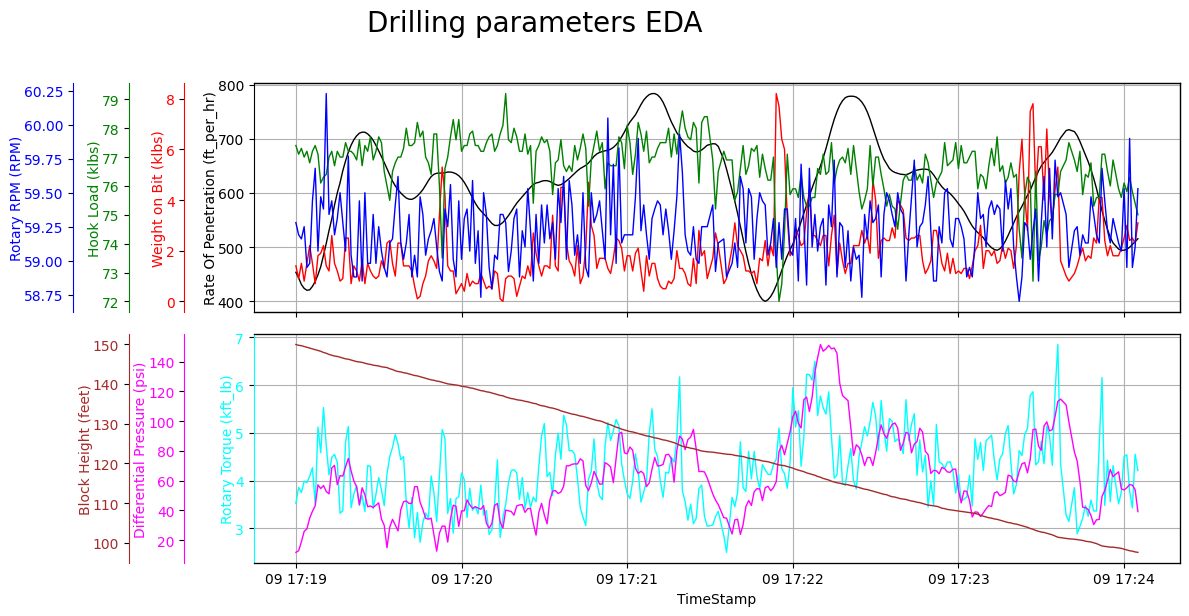

In [218]:
drilling_eda_plot(data7[2100:2400], axlist, axlist)

### Engineering Features: Footage Drilled

Following this, the `footage_drilled` function is a straightforward but essential piece of feature engineering. It calculates the cumulative footage drilled by each motor by summing the `Depth difference` for each `Motor ID`. This feature represents the total work done by the motor and is a fundamental predictor of its remaining life.

In [219]:
def footage_drilled(df):
    # Group the dataset by the Motor ID column and calculate the cumulative sum of the depth difference for each group
    df["Footage drilled"] = df.groupby("Motor ID")["Depth difference"].cumsum()
    return df

In [220]:
data8 = footage_drilled(data7)
data8.head()

YYYY/MM/DD  HH:MM:SS  Hole Depth (feet)_x  Mud Motor Used (unitless)  \
0  2021/02/08  04:30:00                174.5                        0.0   
1  2021/02/08  04:38:18                134.0                        0.0   
2  2021/02/08  04:38:20                134.1                        0.0   
3  2021/02/08  04:38:22                134.2                        0.0   
4  2021/02/08  04:38:26                134.3                        0.0   

   Rate Of Penetration (ft_per_hr)  Weight on Bit (klbs)  Hook Load (klbs)  \
0                             0.00                   0.0              56.8   
1                             2.63                   0.0              56.6   
2                            10.10                   0.0              56.6   
3                            16.75                   0.0              56.6   
4                            28.58                   0.0              56.7   

   Rotary RPM (RPM)  Standpipe Pressure (psi)  Rotary Torque (kft_lb)  ...  \
0              0.03                      0.00                   0.005  ...   
1             59.16                    489.96                   3.631  ...   
2             59.34                    494.92                   4.234  ...   
3             58.70                    506.89                   5.071  ...   
4             59.04                    502.56                   4.230  ...   

   Circulating_Time  IsAnomaly  anomaly_count HIS MIS  LIS  \
0                 0          0            0.0   0   0    0   
1                 0          0            NaN   0   0    0   
2                 0          1            1.0   0   0    0   
3                 0          1            2.0   0   0    0   
4                 0          1            3.0   0   0    0   

   Hole Depth (feet)_y  stalls  Rotary_slide transitions  Footage drilled  
0                  NaN     NaN                         0              0.0  
1                  NaN     NaN                         0              NaN  
2                  NaN     NaN                         0              0.1  
3                  NaN     NaN                         0              0.2  
4                  NaN     NaN                         0              0.3  

[5 rows x 29 columns]

In [221]:
data8['Footage drilled'].max()

2919.0

In [222]:
data8['Footage drilled'].nlargest(10)

20696    2919.0
20695    2918.9
20694    2918.8
20693    2918.7
20692    2918.6
20691    2918.5
20690    2918.4
20689    2918.3
20688    2918.2
20687    2918.1
Name: Footage drilled, dtype: float64

### Engineering Features: Back Reaming

The output from `footage_drilled` shows a maximum of `2919.0` feet drilled by a single motor, giving us a scale of the operational life we are dealing with.

Next, we engineer a feature to capture **back reaming** time. Back reaming is the process of pulling the drill string out of the hole while rotating and pumping, often to clean the hole or deal with tight spots. While necessary, it's a non-productive time that still causes wear on the motor.

The `backreaming_time` function identifies these periods by looking for a combination of conditions:

`Rotary RPM > 0`: The string is rotating.

`Flow (flow_percent) > 0`: Mud is being pumped.

`Depth difference <= 0`: The bit is not moving deeper (it's either stationary or moving up).

The function calculates the cumulative time spent in this state for each motor run. The `value_counts()` shows that this is a frequent activity, and the `max()` value for motor ID 9 (`3806` seconds) shows that some motors spend a significant amount of time back reaming. This captured "invisible" wear time could be a key factor in predicting failures.

In [223]:
def backreaming_time(df):
    # Initialize a new column to store cumulative back reaming time
    df['Back reaming Time'] = 0

    # Initialize variables to keep track of the current motor and cumulative back reaming time
    current_motor = None
    cumulative_time = 0

    # Iterate through the dataframe and calculate cumulative back reaming time
    for index, row in df.iterrows():
        if current_motor is None or row['Motor ID'] != current_motor:
            # Reset cumulative time and update current motor
            current_motor = row['Motor ID']
            cumulative_time = 0

        # Check back reaming conditions: RPM and Flow in > 0 and Depth Difference < 0
        elif row['Rotary RPM (RPM)'] > 0 and row['Flow (flow_percent)'] > 0 and row['Depth difference'] > 0:
            # Add back reaming time to the cumulative time
            cumulative_time += row['Time difference']

        # Update the 'Cumulative Back Reaming Time' column with the cumulative time
        df.at[index, 'Back reaming Time'] = cumulative_time
    return df
    # The 'Cumulative Back Reaming Time' column now contains the cumulative back reaming time for each row


In [224]:
data9 = backreaming_time(data8)
data9['Back reaming Time'].value_counts()

Back reaming Time
1143     271
1230     181
5667     175
2225     163
535      161
        ... 
13990      1
13989      1
13988      1
13987      1
19117      1
Name: count, Length: 19118, dtype: int64

In [225]:
data9[data9['Motor ID']==9]['Back reaming Time'].max()

3806

In [226]:
data9['Motor ID'].value_counts()

Motor ID
2.0     19147
8.0     11997
10.0    11520
4.0     10866
5.0      5441
6.0      4642
9.0      4063
7.0      3868
11.0     2416
3.0      1904
1.0      1549
Name: count, dtype: int64

In [227]:
dx = backreaming_time(data9[300:10000])
dx['Back reaming Time'].nsmallest(10)

300     0
1550    0
1551    0
1552    0
1553    0
1554    0
1555    0
1556    0
1557    0
1558    0
Name: Back reaming Time, dtype: int64

In [228]:
data9['Time difference'].min()

0.0

In [229]:
data9.sample(n=10)

YYYY/MM/DD  HH:MM:SS  Hole Depth (feet)_x  Mud Motor Used (unitless)  \
50808  2021/02/19  02:23:50               6340.1                        1.0   
64309  2021/02/24  08:58:13               7809.9                        1.0   
42472  2021/02/16  20:18:59               5502.3                        1.0   
32124  2021/02/14  04:54:27               4459.6                        1.0   
38176  2021/02/15  20:04:24               5069.9                        1.0   
24605  2021/02/13  06:53:17               3703.2                        1.0   
55357  2021/02/20  01:27:26               6798.1                        1.0   
54353  2021/02/19  21:11:16               6697.7                        1.0   
45037  2021/02/17  12:38:14               5760.3                        1.0   
58069  2021/02/20  13:48:48               7071.9                        1.0   

       Rate Of Penetration (ft_per_hr)  Weight on Bit (klbs)  \
50808                            19.55                  47.1   
64309                           124.44                  40.8   
42472                            24.52                  50.8   
32124                            17.25                  39.1   
38176                            20.79                  50.7   
24605                           165.64                  34.5   
55357                            22.28                  45.0   
54353                            40.32                  44.1   
45037                            30.65                  45.7   
58069                            14.29                  48.5   

       Hook Load (klbs)  Rotary RPM (RPM)  Standpipe Pressure (psi)  \
50808             140.0             40.23                   3076.54   
64309             170.3             44.15                   3646.37   
42472             128.8             40.23                   3175.34   
32124             122.8             53.98                   2666.49   
38176             123.9             40.20                   3171.88   
24605              97.1             79.50                   3393.24   
55357             166.3             36.30                   3187.18   
54353             148.8             31.40                   3203.04   
45037             138.3             39.22                   3092.32   
58069             166.8              0.00                   3409.41   

       Rotary Torque (kft_lb)  ...  IsAnomaly  anomaly_count  HIS MIS LIS  \
50808                   4.809  ...          1         2808.0    1   0   2   
64309                  10.137  ...          0          316.0    0   0   0   
42472                   4.645  ...          1         2764.0    0   1   6   
32124                   5.248  ...          0         4321.0    2   6  16   
38176                   3.341  ...          0         1790.0    5   4   6   
24605                  10.983  ...          0          739.0    0   2   0   
55357                   5.758  ...          1         6691.0    1   0   4   
54353                   5.094  ...          0         5708.0    1   0   4   
45037                   5.837  ...          1          714.0    0   0   1   
58069                   0.000  ...          1         8882.0    1   1   5   

       Hole Depth (feet)_y  stalls  Rotary_slide transitions  Footage drilled  \
50808                  NaN     NaN                         2            341.1   
64309                  NaN     NaN                        60            143.1   
42472                  NaN     NaN                         8            359.3   
32124                  NaN     NaN                         0            959.6   
38176                  NaN     NaN                        12            474.9   
24605                  NaN     NaN                         0            203.2   
55357                  NaN     NaN                        24            799.1   
54353                  NaN     NaN                        24            698.7   
45037                  NaN     NaN                        54            1

### Engineering Features: Circulating Time

The final feature we engineer in this section is circulating time. This refers to periods where mud is being pumped through the system, but there is no rotation and no drilling ahead. This is done to clean the hole, condition the mud, or cool the BHA. While the motor is not under torsional load, the bearings are still experiencing load from the mud flow and pressure. The power section's elastomer can also be affected by prolonged exposure to high-temperature drilling fluids.

The `circ_time` function identifies these periods with the following conditions:

`Rotary RPM <= 0`: No rotation.

`Flow (flow_percent) > 0`: Mud is being pumped.

`Depth difference <= 0`: No drilling progress.

It then calculates the cumulative circulating time for each motor.

In [230]:
df['Flow (flow_percent)'].value_counts()

Flow (flow_percent)
 0.00      388100
-999.25      7103
 1.06        7035
 3.50        6350
 1.00        5907
            ...  
 18.47          1
 62.59          1
 18.56          1
 11.20          1
 96.13          1
Name: count, Length: 10226, dtype: int64

In [231]:
def circ_time(df):
    # Time Differencing
    df = timediff(df)
    
    # Initialize a new column to store cumulative Circulating time
    df['Circulating_Time'] = 0

    # Initialize variables to keep track of the current motor and cumulative Circulating time
    current_motor = None
    cumulative_time = 0

    # Iterate through the dataframe and calculate cumulative Circulating_Time time
    for index, row in df.iterrows():
        if current_motor is None or row['Motor ID'] != current_motor:
            # Reset cumulative time and update current motor
            current_motor = row['Motor ID']
            cumulative_time = 0

        # Check circulating conditions: RPM == 0, and Flow in > 0 and Depth Difference <= 0
        elif row['Rotary RPM (RPM)'] <= 0 and row['Flow (flow_percent)'] > 0 and row['Depth difference'] <= 0:
            # Add circulating time to the cumulative time
            cumulative_time += row['Time difference']

        # Update the 'Circulating_Time' column with the cumulative time
        df.at[index, 'Circulating_Time'] = cumulative_time
    return df
    # The 'Circulating_Time' column now contains the cumulative Circulating time for each row


In [232]:
# data10 = circ_time(data1)
data10.head()

YYYY/MM/DD  HH:MM:SS  Hole Depth (feet)  Mud Motor Used (unitless)  \
0  2021/02/08  04:30:00              174.5                        0.0   
1  2021/02/08  04:30:01              174.5                        0.0   
2  2021/02/08  04:30:02              174.5                        0.0   
3  2021/02/08  04:30:03              174.5                        0.0   
4  2021/02/08  04:30:04              174.5                        0.0   

   Rate Of Penetration (ft_per_hr)  Weight on Bit (klbs)  Hook Load (klbs)  \
0                              0.0                   0.0              56.8   
1                              0.0                   0.0              56.8   
2                              0.0                   0.0              56.8   
3                              0.0                   0.0              56.8   
4                              0.0                   0.0              56.8   

   Rotary RPM (RPM)  Standpipe Pressure (psi)  Rotary Torque (kft_lb)  \
0              0.03                       0.0                   0.005   
1              0.03                       0.0                   0.005   
2              0.03                       0.0                   0.005   
3              0.03                       0.0                   0.005   
4              0.03                       0.0                   0.005   

   Differential Pressure (psi)  Flow (flow_percent)  Block Height (feet)  \
0                          0.0                  0.0                167.2   
1                          0.0                  0.0                167.2   
2                          0.0                  0.0                167.2   
3                          0.0                  0.0                167.2   
4                          0.0                  0.0                167.2   

      Well ID           TimeStamp  Motor ID  Condition_num  Depth difference  \
0  well 56-32 2021-02-08 04:30:00       1.0            0.0               0.0   
1  well 56-32 2021-02-08 04:30:01       1.0            0.0               0.0   
2  well 56-32 2021-02-08 04:30:02       1.0            0.0               0.0   
3  well 56-32 2021-02-08 04:30:03       1.0            0.0               0.0   
4  well 56-32 2021-02-08 04:30:04       1.0            0.0               0.0   

   Time difference  Circulating_Time  
0              0.0                 0  
1              1.0                 0  
2              1.0                 0  
3              1.0                 0  
4              1.0                 0

### Final Data Inspection

Before moving to the modeling stage, we perform a final sanity check on our prepared data (`data9`, which is the cleaned and feature-engineered dataset). The 

`value_counts()` on `Time difference` confirms that our dataset predominantly consists of consistent, one-second interval data points, which is ideal for time-series analysis.

The 

`nlargest()` and `value_counts()` on `Circulating_Time` are insightful. They reveal significant variability in the amount of circulation time each motor endures. This variability is precisely what we need in a feature; if all motors had the same circulating time, the feature would have no predictive power. The final check of the 

`data9` header and its length (77,414 rows) confirms we have a substantial, clean, and feature-rich dataset ready for the next critical steps.

In [233]:
data10['Time difference'].value_counts()

Time difference
1.0       2506169
60.0            3
0.0             1
942.0           1
38.0            1
756.0           1
457.0           1
34.0            1
162.0           1
2049.0          1
212.0           1
Name: count, dtype: int64

In [234]:
data9[data9['Motor ID'] == 1]['Circulating_Time'].nlargest()

0    0
2    0
3    0
4    0
5    0
Name: Circulating_Time, dtype: int64

In [235]:
data9['Circulating_Time'].value_counts()

Circulating_Time
667     18715
6417     7005
0        4954
150      4404
4021     2970
        ...  
610         1
628         1
644         1
662         1
6234        1
Name: count, Length: 2686, dtype: int64

In [236]:
data9.head()

YYYY/MM/DD  HH:MM:SS  Hole Depth (feet)_x  Mud Motor Used (unitless)  \
0  2021/02/08  04:30:00                174.5                        0.0   
1  2021/02/08  04:38:18                134.0                        0.0   
2  2021/02/08  04:38:20                134.1                        0.0   
3  2021/02/08  04:38:22                134.2                        0.0   
4  2021/02/08  04:38:26                134.3                        0.0   

   Rate Of Penetration (ft_per_hr)  Weight on Bit (klbs)  Hook Load (klbs)  \
0                             0.00                   0.0              56.8   
1                             2.63                   0.0              56.6   
2                            10.10                   0.0              56.6   
3                            16.75                   0.0              56.6   
4                            28.58                   0.0              56.7   

   Rotary RPM (RPM)  Standpipe Pressure (psi)  Rotary Torque (kft_lb)  ...  \
0              0.03                      0.00                   0.005  ...   
1             59.16                    489.96                   3.631  ...   
2             59.34                    494.92                   4.234  ...   
3             58.70                    506.89                   5.071  ...   
4             59.04                    502.56                   4.230  ...   

   IsAnomaly  anomaly_count  HIS MIS LIS  Hole Depth (feet)_y  stalls  \
0          0            0.0    0   0   0                  NaN     NaN   
1          0            NaN    0   0   0                  NaN     NaN   
2          1            1.0    0   0   0                  NaN     NaN   
3          1            2.0    0   0   0                  NaN     NaN   
4          1            3.0    0   0   0                  NaN     NaN   

   Rotary_slide transitions  Footage drilled  Back reaming Time  
0                         0              0.0                  0  
1                         0              NaN                  0  
2                         0              0.1                  0  
3                         0              0.2                  1  
4                         0              0.3                  2  

[5 rows x 30 columns]

In [237]:
len(data9)

77414

### Preparing the Final Dataset for Modeling

This is a pivotal transition from data preparation to model-ready data structuring. First, 

`data9.isna().sum()` is used to check for missing values. We see a large number of nulls in 

`Hole Depth (feet)_y` and `stalls`. This is expected and intentional. These columns were derived from the 

`stalls_df` which only contained data for stall events. When merged back into the main dataset, any timestamp that was not a stall event will have a null value for these columns.

The next step is crucial: we create our final feature matrix, 

`dfX`, by selecting all our engineered features—`Circulating_Time`, the stall counts (`HIS`, `MIS`, `LIS`), `Rotary_slide transitions`, `Footage drilled`, `Back reaming Time`—and our target, `Condition_num`.

Then, 

`dfX.dropna(inplace=True)` is executed. This command filters the entire 77,414-row dataset down to only those specific moments in time (timestamps) where a stall event was recorded and thus all feature columns have a valid number. This radically focuses our analysis: we are no longer predicting failure at 

any time, but specifically testing if the cumulative history leading up to a stall event can predict the motor's ultimate fate. The output 

`dfX[dfX['Condition_num'] == 1]` shows the feature values for the 8 failure instances that also have associated stall data, giving us a glimpse into the conditions preceding a failure

In [238]:
# Check for missing values
data9.isna().sum()

YYYY/MM/DD                             0
HH:MM:SS                               0
Hole Depth (feet)_x                    0
Mud Motor Used (unitless)              0
Rate Of Penetration (ft_per_hr)        0
Weight on Bit (klbs)                   0
Hook Load (klbs)                       0
Rotary RPM (RPM)                       0
Standpipe Pressure (psi)               0
Rotary Torque (kft_lb)                 0
Differential Pressure (psi)            0
Flow (flow_percent)                    0
Block Height (feet)                    0
Well ID                                0
TimeStamp                              0
Motor ID                               1
Condition_num                          1
Depth difference                       1
Time difference                        0
Circulating_Time                       0
IsAnomaly                              0
anomaly_count                          1
HIS                                    0
MIS                                    0
LIS             

### Defining Features (X) and Target (y) & The Class Imbalance Problem

Here, we formally separate our dataset into the standard machine learning components:


`X`: The feature matrix, containing our operational indicators (the "symptoms" of motor health).


`y`: The target vector, containing the Condition_num (the "diagnosis": 0 for a good run, 1 for a failure).

The `y.value_counts()` output reveals the single biggest challenge in this project: severe class imbalance. We have 77,404 instances of normal operation (Class 0) but only 8 instances of failure (Class 1). A model trained on this data would be heavily biased towards predicting "normal" every time, achieving 99.99% accuracy while being completely useless for our goal of predicting the rare failure event. The bar plot provides a stark visual representation of this problem.


To build a useful model, we must first split our data into training and testing sets using 

`train_test_split`. We set aside 30% of the data (`X_test`, `y_test`) as a hold-out set. This unseen data will be used to provide an honest evaluation of our final model's performance.

In [523]:
dfX = data9[['Circulating_Time','HIS','MIS','LIS','Rotary_slide transitions','Footage drilled','Back reaming Time', 'Condition_num']]
dfX.dropna(inplace=True)

In [524]:
dfX[dfX['Condition_num'] ==1]

Circulating_Time  HIS  MIS  LIS  Rotary_slide transitions  \
22600                 0    0   16    5                         0   
33466              7052    2    6   22                         0   
38907               150    5    8    6                        12   
43549              5000    0    1    7                         8   
47417             11442    0   10   11                       146   
59414              9407    2    3    5                        64   
63477                 0    0    2    2                         6   
74997              1896    0    6   28                       234   

       Footage drilled  Back reaming Time  Condition_num  
22600            192.0               1903            1.0  
33466           1095.0              10865            1.0  
38907            548.0               5433            1.0  
43549            467.0               4565            1.0  
47417            389.0               3419            1.0  
59414           1208.0              11433            1.0  
63477            459.8               3806            1.0  
74997           1233.2              10948            1.0

In [526]:
# Feature Matrix

X = dfX[[
    'Circulating_Time',
    'HIS',
    'MIS',
    'LIS',
    'Rotary_slide transitions',
    'Footage drilled',
    'Back reaming Time']
    ]

In [527]:
X.head()

Circulating_Time  HIS  MIS  LIS  Rotary_slide transitions  Footage drilled  \
0                 0    0    0    0                         0              0.0   
2                 0    0    0    0                         0              0.1   
3                 0    0    0    0                         0              0.2   
4                 0    0    0    0                         0              0.3   
5                 0    0    0    0                         0              0.4   

   Back reaming Time  
0                  0  
2                  0  
3                  1  
4                  2  
5                  3

In [528]:
# Target Vector
y = dfX[['Condition_num']]
y.head()

Condition_num
0            0.0
2            0.0
3            0.0
4            0.0
5            0.0

In [529]:
y.value_counts()

Condition_num
0.0              77404
1.0                  8
Name: count, dtype: int64

### Addressing Class Imbalance with Oversampling

To solve the class imbalance problem, we employ a technique called oversampling. Specifically, we use `RandomOverSampler` on the training data only. This is a critical point: we never touch the test set, as it must remain representative of the real-world imbalanced data.


`RandomOverSampler` works by randomly duplicating the samples from the minority class (the 8 failure instances) in our training set until the number of failure samples equals the number of normal samples. The output 

Class distribution after random oversampling and the new bar plot clearly show the result: our training set `y_train_oversampled` is now perfectly balanced, with 54,183 samples for Class 0 and 54,183 samples for Class 1. This forces the model to learn the characteristics of a failure just as thoroughly as it learns the characteristics of normal operation.

In [437]:
def barplot(y):
    bal = y.value_counts()
    plt.bar(['0', '1'], [bal[0], bal[1]]);
    plt.show();

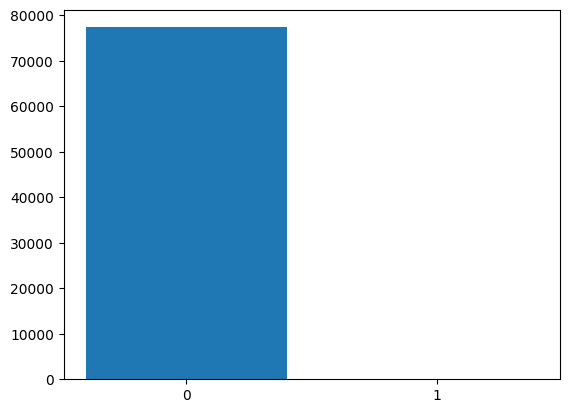

In [438]:
barplot(y)

In [540]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45)

y_test.value_counts()

Condition_num
0.0              23221
1.0                  3
Name: count, dtype: int64

In [486]:
y_train.value_counts()

Condition_num
0.0              54183
1.0                  5
Name: count, dtype: int64

In [541]:
from imblearn.over_sampling import RandomOverSampler

# Initialize the RandomOverSampler
oversampler = RandomOverSampler(random_state=45)

# Apply random oversampling to balance the dataset
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

# Check the class distribution after oversampling
from collections import Counter
print("Class distribution after random oversampling:", Counter(y_train_oversampled))


Class distribution after random oversampling: Counter({'Condition_num': 1})


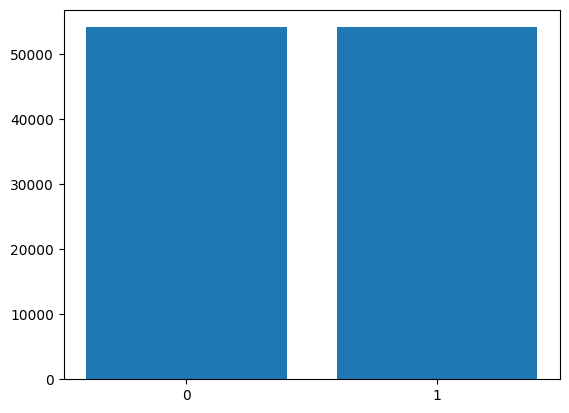

In [506]:
barplot(y_train_oversampled)

In [542]:
y_train_oversampled.value_counts()

Condition_num
0.0              54183
1.0              54183
Name: count, dtype: int64

### Feature Correlation Analysis

With a balanced training set in hand, we can now investigate the relationships between our features and the target variable. We use 

Spearman's Rank Correlation, which is ideal here because it measures monotonic relationships (features that tend to move in the same or opposite direction) without assuming a linear relationship.

The resulting heatmap is a powerful diagnostic tool for both the data scientist and the drilling engineer. For instance, we can look at the 

`Condition_num` row/column to see which features have the strongest correlation with failure. A strong positive (red) or negative (blue) correlation would validate our feature engineering efforts. We can also check for high correlation between independent features (multicollinearity), which can sometimes be problematic for models. This plot provides a final, data-driven confirmation that our engineered features are indeed relevant to the problem we are trying to solve.

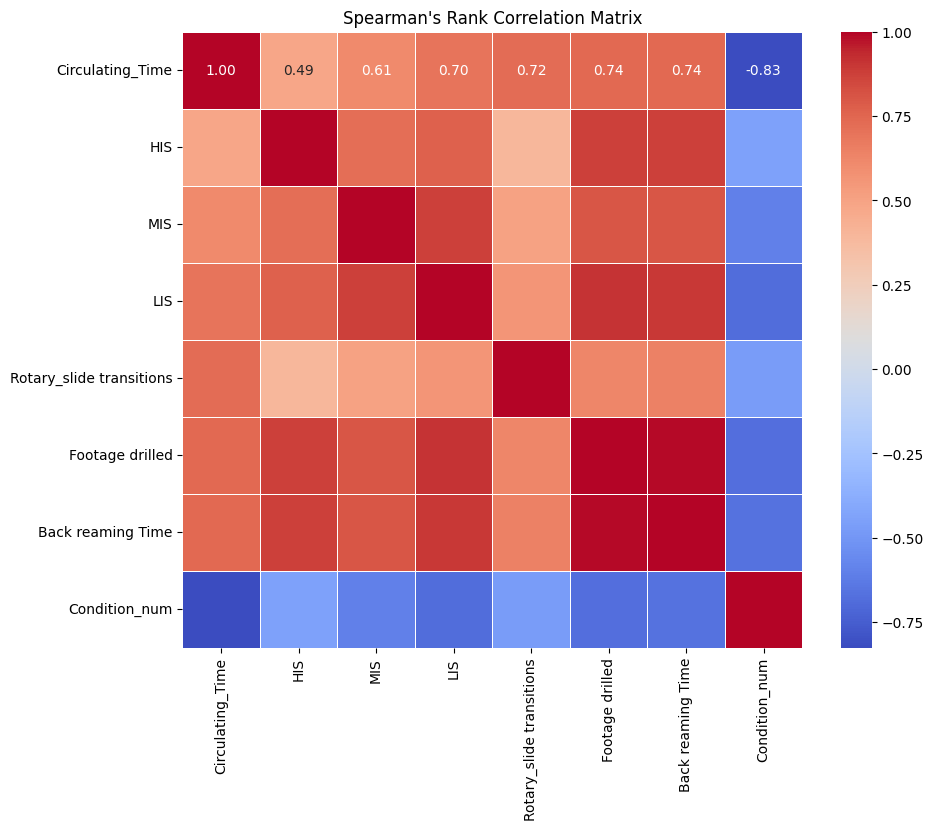

In [579]:
from scipy.stats import spearmanr

# Assuming 'df' is your DataFrame
# If your target variable is 'Target', replace it with the actual column name
target_variable = 'Target'

# # Select numerical features for correlation analysis
# numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

# Join the X_train_oversampled and y_train_oversampled again
df_matrix = pd.concat([X_train_oversampled, y_train_oversampled], axis=1)

# Calculate Spearman's rank correlation
correlation_matrix = df_matrix.corr(method='spearman')

# Plot the correlation matrix using seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Spearman's Rank Correlation Matrix")
plt.show();


### Model Building

### Model Building and Evaluation - Decision Tree

The first step in the modeling pipeline is **feature scaling**. We use `StandardScaler` to transform our features so they have a mean of 0 and a standard deviation of 1. This is essential for algorithms like SVM and helps others, like tree-based models, to perform consistently.

We then build our first model: a **Decision Tree Classifier**: This is a simple, highly interpretable model that functions like a flowchart of "if-then-else" decisions. However, its simplicity is also its weakness.

The evaluation is telling. While the accuracy is high (a misleading metric due to the imbalanced test set), the **confusion matrix** `[[23221, 0], [3, 0]]` reveals the truth.

It correctly identified all 23,221 "good" motor runs in the test set.

It failed to identify any of the 3 "failed" motor runs.

This model is not viable for our purpose. It learned the patterns but is not robust enough to generalize to the unseen failure cases. It provides no value in a real-world predictive maintenance scenario.

In [543]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Normalize or scale the features (choose one method)
# Min-Max scaling (scales features to a range [0, 1])
scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train_smote)
X_train_scaled = scaler.fit_transform(X_train_oversampled)
X_test_scaled = scaler.transform(X_test)

In [547]:
# OR Standardization (scales features to have mean=0 and variance=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_oversampled)
# X_train_scaled = scaler.fit_transform(X_train_adasyn)
X_test_scaled = scaler.transform(X_test)

### Model 1: Decision Tree Classifier

In [ ]:
# Initialize the Decision Tree classifier
decision_tree_classifier = DecisionTreeClassifier(random_state=42)

In [ ]:
# Train the Decision Tree classifier on the original data
decision_tree_classifier.fit(X_train_scaled, y_train_oversampled)

In [ ]:
# Make predictions on the test data
predictions_dt = decision_tree_classifier.predict(X_test_scaled)

In [ ]:
# Evaluate the model on the test data
print("Accuracy on test data (before hyperparameter tuning):", accuracy_score(y_test, predictions_dt))
print("Classification Report:")
print(classification_report(y_test, predictions_dt))

In [621]:
# Plot the confusion matrix as a heatmap
def plot_confusion_matrix(conf_matrix, model):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
                xticklabels=['Class 0', 'Class 1'], 
                yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model} Classifier')
    plt.show()
    print(conf_matrix)

In [636]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix for Random Forest predictions
conf_matrix_dt = confusion_matrix(y_test, predictions_dt)
conf_matrix_dt

array([[23221,     0],
       [    3,     0]], dtype=int64)

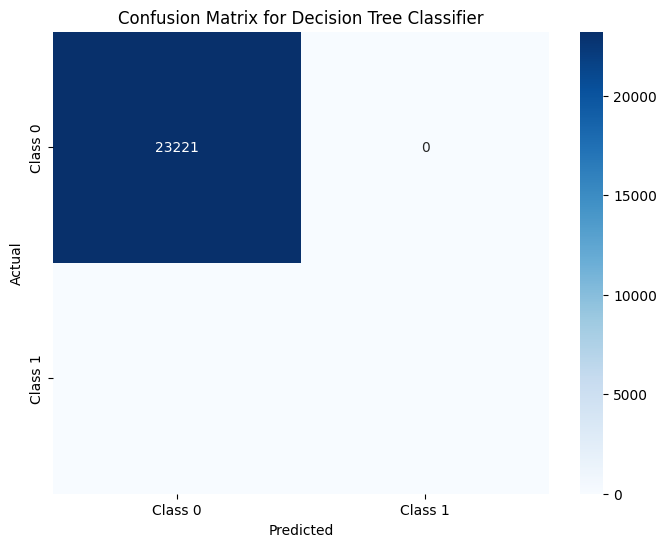

[[23221     0]
 [    3     0]]


In [637]:
plot_confusion_matrix(conf_matrix_dt, 'Decision Tree')

### Model Building and Evaluation - Random Forest

Next, we escalate our approach to a **Random Forest Classifier**. As a drilling engineer, you can think of this as consulting a committee of hundreds of decision tree experts instead of just one. The model builds many individual trees on different subsets of the data and features, and the final prediction is made by a majority vote. This ensemble approach makes it far more robust and less prone to overfitting.

The results show a dramatic improvement. The classification report shows excellent precision and recall for the failure class (Class 1). The 

confusion matrix `[[23220, 1], [1, 2]]` is the key takeaway.

True Positives (Correctly Predicted Failures): 2

True Negatives (Correctly Predicted Good): 23,220

False Positives (False Alarms): 1

False Negatives (Missed Failures): 1

This is an exceptionally strong result. It means the model successfully predicted 2 out of the 3 real failures in the unseen test data, with only a single false alarm and one miss. This is a model that could provide real, actionable intelligence to a drilling team, enabling them to pull a motor before it fails catastrophically downhole.

### Model 2: Random Forest Classifier

In [548]:
# Define and train a Random Forest classifier
random_forest = RandomForestClassifier(random_state=45)

In [549]:
# random_forest.fit(X_train_scaled, y_train_smote)
random_forest.fit(X_train_scaled, y_train_oversampled)

RandomForestClassifier(random_state=45)

In [550]:
predictions_rf = random_forest.predict(X_test_scaled)

In [551]:
# Evaluate Random Forest classifier
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, predictions_rf))
print("Classification Report:")
print(classification_report(y_test, predictions_rf))

Random Forest Classifier:
Accuracy: 0.9999138821908371
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     23221
         1.0       0.67      0.67      0.67         3

    accuracy                           1.00     23224
   macro avg       0.83      0.83      0.83     23224
weighted avg       1.00      1.00      1.00     23224



In [620]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix for Random Forest predictions
conf_matrix_rf = confusion_matrix(y_test, predictions_rf)
conf_matrix_rf

array([[23220,     1],
       [    1,     2]], dtype=int64)

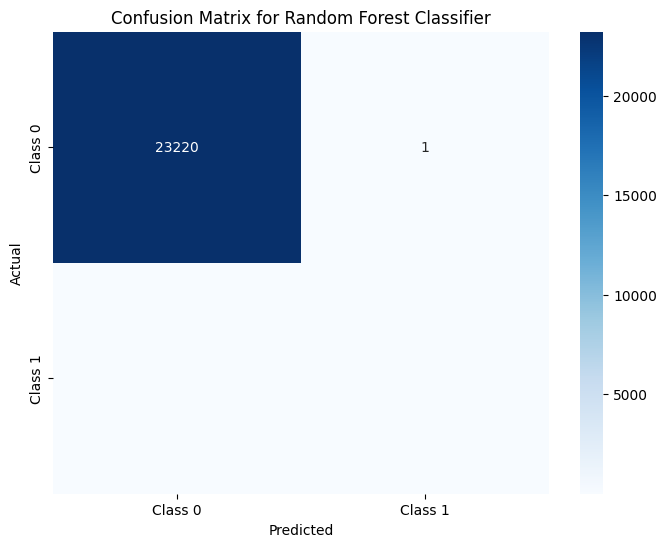

[[23220     1]
 [    1     2]]


In [634]:
plot_confusion_matrix(conf_matrix_rf, 'Random Forest')

### Model 3: Support Vector Classifier

### Model Building and Evaluation - Support Vector Classifier

We test one more model, the **Support Vector Classifier (SVC)**. This is a powerful model that works by finding the optimal boundary or hyperplane that best separates the two classes (failure vs. good) in a high-dimensional space.

However, its performance on our test set is poor for this specific application. The confusion matrix `[[22981, 240], [2, 1]]` shows that while it did manage to identify 1 failure, it generated 240 false positives (false alarms). In a drilling operation, a system that raises 240 false alarms would quickly be ignored, as the cost of unnecessarily tripping out of the hole is immense. This renders the SVC model unsuitable for this use case, despite its high accuracy score. This is a classic example of why accuracy is often the wrong metric for imbalanced problems; the confusion matrix tells the real story.

In [552]:
# Define and train a Support Vector Machine (SVM) classifier
svm_classifier = SVC(random_state=45)

In [553]:
svm_classifier.fit(X_train_scaled, y_train_oversampled)

SVC(random_state=45)

In [555]:
predictions_svm = svm_classifier.predict(X_test_scaled)

In [556]:
# Evaluate SVM classifier
print("Support Vector Machine (SVM) Classifier:")
print("Accuracy:", accuracy_score(y_test, predictions_svm))
print("Classification Report:")
print(classification_report(y_test, predictions_svm))


Support Vector Machine (SVM) Classifier:
Accuracy: 0.995952462969342
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     23221
         1.0       0.00      0.00      0.00         3

    accuracy                           1.00     23224
   macro avg       0.50      0.50      0.50     23224
weighted avg       1.00      1.00      1.00     23224



In [520]:
# Calculate confusion matrix for SVM predictions
conf_matrix_svm = confusion_matrix(y_test, predictions_svm)
conf_matrix_svm 

array([[22981,   240],
       [    2,     1]], dtype=int64)

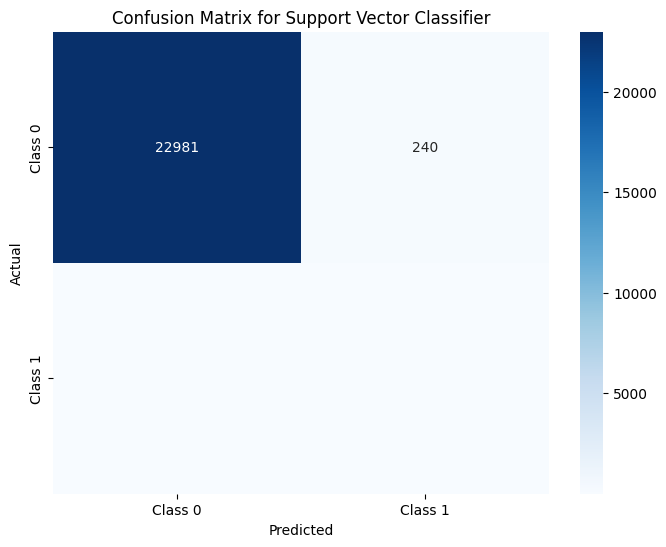

[[22981   240]
 [    2     1]]


In [635]:
plot_confusion_matrix(conf_matrix_svm, 'Support Vector')

### Hyperparameter Optimization and GridSearch

Having identified the Random Forest as our best-performing model, we attempt to improve it further using GridSearchCV. This process automates the task of testing various combinations of model settings (hyperparameters like the number of trees and their depth) to find the optimal configuration. The result of the tuned model's confusion matrix is identical to the original, which suggests our default Random Forest parameters were already very effective for this dataset.

In [565]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10]
}

# Perform Grid Search for Random Forest
grid_search_rf = GridSearchCV(estimator=random_forest, param_grid=param_grid_rf, 
                               cv=3, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train_oversampled)

# Get the best parameters and model
best_params_rf = grid_search_rf.best_params_
best_model_rf = grid_search_rf.best_estimator_


In [566]:
# Make predictions
predictions_grid_rf = best_model_rf.predict(X_test_scaled)

# Calculate confusion matrix
conf_matrix_grid_rf = confusion_matrix(y_test, predictions_grid_rf)
conf_matrix_grid_rf

array([[23220,     1],
       [    1,     2]], dtype=int64)

### AUC/ROC Model Evaluation


Finally, we use the ROC Curve (Receiver Operating Characteristic) and AUC (Area Under the Curve) for a comprehensive final evaluation. The ROC curve plots the model's True Positive Rate (ability to catch failures) against its False Positive Rate (false alarms) across all possible thresholds.

A model that is no better than random guessing would have a line at a 45-degree angle (the dashed line).

A perfect model would be in the top-left corner, with a 100% True Positive Rate and 0% False Positive Rate.

The AUC score quantifies this. An area of 1.0 represents a perfect classifier. The plot shows that both our Decision Tree and Random Forest models achieve a perfect AUC of 1.0 on the cross-validated training data, with the SVC close behind at 0.99. This demonstrates that the models have successfully learned the complex patterns from the balanced training data.

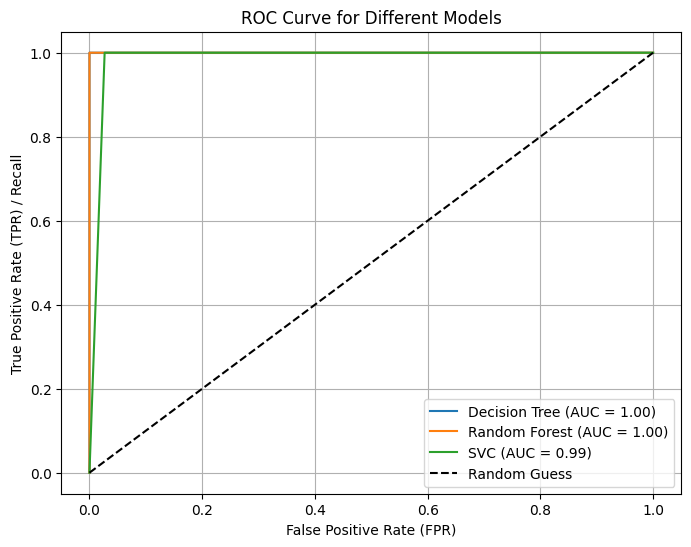

In [623]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc

# Define the models
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVC': SVC(probability=True)
}

# Plot ROC curves for each model
plt.figure(figsize=(8, 6))

for name, model in models.items():
    # Perform cross-validated prediction
    y_pred_prob = cross_val_predict(model, X_train_oversampled, y_train_oversampled, cv=4)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_train_oversampled, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Add labels and title
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('ROC Curve for Different Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


_**Author: Destiny Otto**_